In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import scipy
from tqdm import tqdm
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import datetime
from warnings import filterwarnings
filterwarnings('ignore')

Данный участок кода агрегирует по неделям пользования карты средний чек и среднее количество покупок.

In [166]:
clients = pd.read_csv('clients.csv')
purchases = pd.read_csv('purchases.csv', usecols=['client_id', 'transaction_id', 'transaction_datetime', 'purchase_sum'])
purchases.transaction_datetime = pd.to_datetime(purchases.transaction_datetime).dt.normalize()
clients.first_issue_date = pd.to_datetime(clients.first_issue_date).dt.normalize()
purchases = purchases.drop_duplicates().reset_index(drop=True)
df = pd.merge(purchases[['client_id', 'purchase_sum', 'transaction_datetime']], clients[['client_id', 'first_issue_date']], on='client_id', how='left')
df['week_num'] = (df.transaction_datetime - df.first_issue_date).dt.days // 7 + 1
df = df[df.week_num >= 1]
avg_check = df.groupby('week_num').purchase_sum.mean().reset_index()
avg_check.purchase_sum =  avg_check.purchase_sum.astype(int)
avg_check.columns = ['week_num', 'avg_check']
avg_purch_count = df.groupby(['client_id', 'week_num']).purchase_sum.count().reset_index().groupby('week_num').purchase_sum.mean().reset_index()
avg_purch_count.columns = ['week_num', 'avg_purch_count']
avg_purch_count['avg_purch_count'] = avg_purch_count['avg_purch_count'].apply(lambda x: np.round(x, 2))
avg_purch = pd.merge(avg_purch_count, avg_check, on='week_num')

In [167]:
avg_purch.to_csv('avg_purch.csv', index=False)

Данный участок кода агрегирует по неделям пользования карты количество уникальных продуктов в корзине и количество продуктов в корзине.

In [160]:
purchases = pd.read_csv('purchases.csv', usecols=['client_id', 'transaction_id', 'transaction_datetime', 'product_quantity', 'product_id'])
purchases.transaction_datetime = pd.to_datetime(purchases.transaction_datetime).dt.normalize()
purchases = purchases.groupby(['client_id', 'transaction_id', 'transaction_datetime']).agg({'product_quantity': 'sum', 'product_id': 'count'}).reset_index()
purchases = purchases.rename({
  'product_quantity': 'num_products',
  'product_id': 'num_unique_products'  
}, axis=1)
purchases.num_products = purchases.num_products.astype(int)
df = pd.merge(purchases[['client_id', 'num_products', 'num_unique_products', 'transaction_datetime']], clients[['client_id', 'first_issue_date']], on='client_id', how='left')
df['week_num'] = (df.transaction_datetime - df.first_issue_date).dt.days // 7 + 1
df = df[df.week_num >= 1]
avg_cart = df.groupby('week_num')[['num_products', 'num_unique_products']].mean().reset_index()
avg_cart.columns = ['week_num', 'num_products', 'num_unique_products']
avg_cart['num_products'] = avg_cart['num_products'].apply(lambda x: np.round(x, 2))
avg_cart['num_unique_products'] = avg_cart['num_unique_products'].apply(lambda x: np.round(x, 2))

In [162]:
avg_cart.to_csv('avg_cart.csv', index=False)

Данный участок кода агрегирует по неделям пользования карты средние траты бонусных баллов: общее количество, обычных и особых.

In [155]:
purchases = pd.read_csv('purchases.csv', usecols=['client_id', 'transaction_id', 'transaction_datetime', 'regular_points_spent', 'express_points_spent'])
purchases = purchases.drop_duplicates().reset_index(drop=True)
purchases.transaction_datetime = pd.to_datetime(purchases.transaction_datetime).dt.normalize()
purchases['total_points_spent'] = purchases['regular_points_spent'] + purchases['express_points_spent']

purchases = purchases.groupby(['client_id', 'transaction_id', 'transaction_datetime'])[['regular_points_spent', 'express_points_spent', 'total_points_spent']].sum().reset_index()
df = pd.merge(purchases[['client_id', 'transaction_datetime', 'regular_points_spent', 'express_points_spent', 'total_points_spent']], clients[['client_id', 'first_issue_date']], on='client_id', how='left')
df['week_num'] = (df.transaction_datetime - df.first_issue_date).dt.days // 7 + 1
df = df[df.week_num >= 1]
avg_points_expences = df.groupby('week_num')[['regular_points_spent', 'express_points_spent', 'total_points_spent']].mean().apply(lambda x: -np.round(x, 2)).reset_index()
avg_points_expences.columns = [
    'week_num', 'avg_regular_points_spent', 'avg_express_points_spent', 'avg_total_points_spent'
]

In [ ]:
avg_points_expences.to_csv('avg_points_expences.csv', index=False)

In [5]:
avg_purch  = pd.read_csv('avg_purch.csv')
avg_points_expences = pd.read_csv('avg_points_expences.csv')
avg_cart = pd.read_csv('avg_cart.csv')
df = pd.merge(pd.merge(avg_purch, avg_points_expences, on='week_num'), avg_cart, on='week_num')
df = df[df.week_num < 90]

In [14]:
rename_dict = {
    'week_num': 'Номер недели',
    'avg_purch_count': 'Среднее количество покупок',
    'avg_check': 'Средний чек',
    'avg_regular_points_spent': 'Средние потраченные регулярные баллы',
    'avg_express_points_spent': 'Средние потраченные экспресс баллы',
    'avg_total_points_spent': 'Средние потраченные баллы всего',
    'num_products': 'Количество товаров',
    'num_unique_products': 'Количество уникальных товаров'
}
df = df.rename(columns=rename_dict)

In [51]:
sns.set_style('darkgrid')
sns.set_palette('bright')

Графическое изображение для агрегированных признаков по дням недели пользования бонусной картой.

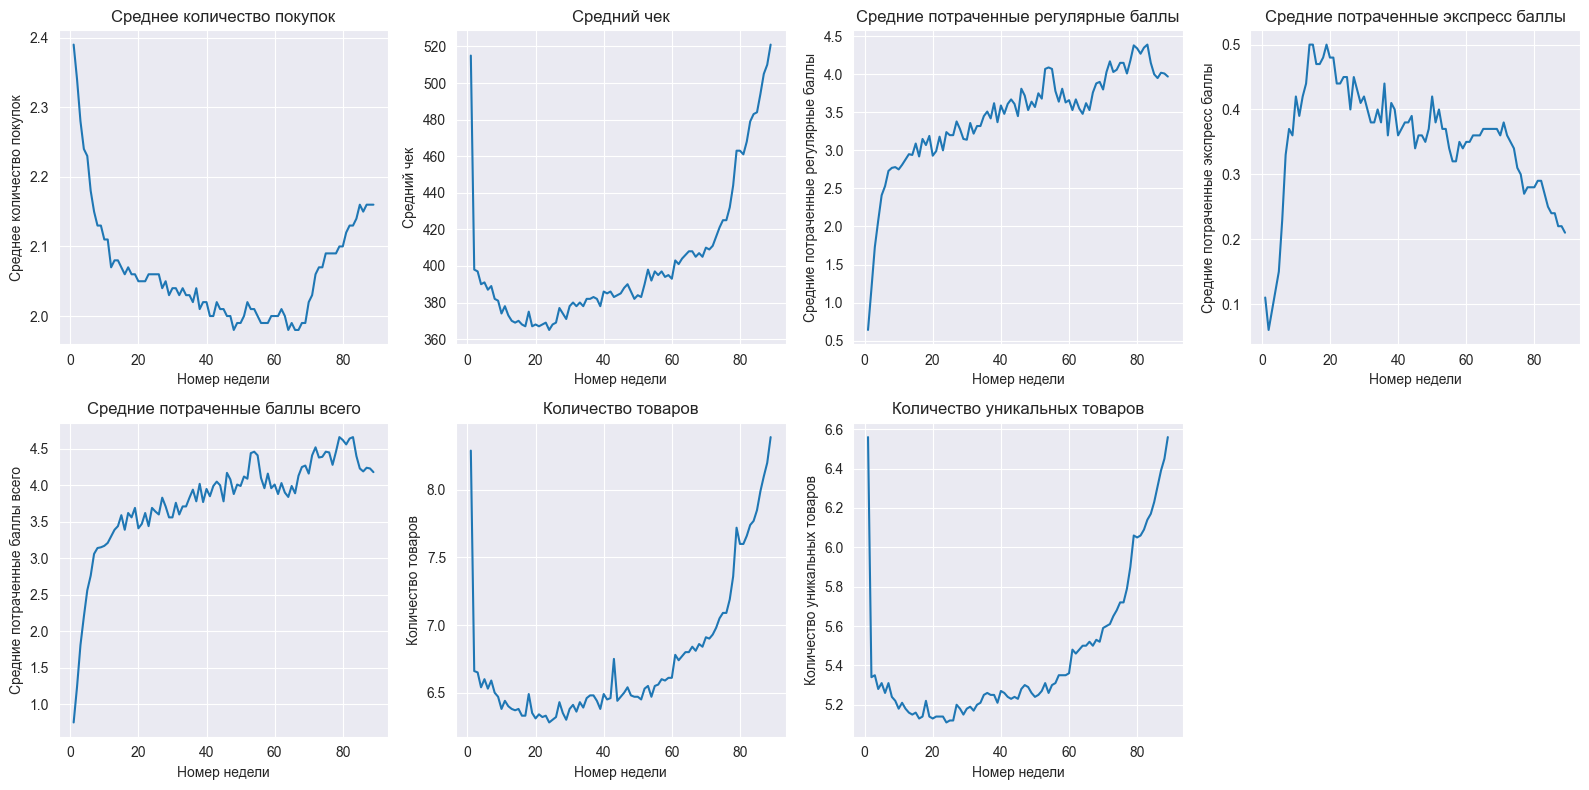

In [20]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for i, col in enumerate(df.columns[1:]):
    row = i // 4
    col_num = i % 4
    sns.lineplot(x='Номер недели', y=col, data=df, ax=axs[row, col_num])
    axs[row, col_num].set_xlabel('Номер недели')
    axs[row, col_num].set_ylabel(col)
    axs[row, col_num].set_title(f'{col}')

fig.delaxes(axs[1, 3])

plt.tight_layout()
plt.show()

В первую неделю после получения карты лояльности наблюдается максимальное количество покупок. Этот показатель остается на высоком уровне в течение всего первого месяца, после чего происходит значительное снижение. Однако после 70-й недели фиксируется новый всплеск покупок, хотя он не достигает показателей первых недель.

Средний чек демонстрирует схожую динамику, но с некоторыми отличиями: максимальный показатель наблюдается также в первую неделю, затем следует резкое снижение, которое продолжается до 60-70 недели. После этого происходит резкий рост, в результате чего уровень среднего чека приближается к показателям первой недели.

Среднее количество использованных бонусных баллов увеличивается в основном за счет обычных бонусов, которые поступательно растут. Максимальное использование экспресс-баллов наблюдается на 20-й неделе, что, вероятно, связано с таргетированной промоакцией для новых клиентов. После этого их использование заметно снижается.

Динамика количества товаров в корзине и числа уникальных товаров также схожа: максимальные значения достигаются в первую неделю, затем наблюдается резкий рост после 70-й недели.

In [21]:
df = pd.read_csv('purchases.csv', usecols=['client_id', 'transaction_id', 'purchase_sum'])
df = df.drop_duplicates()

In [32]:
first_week = avg_purch[avg_purch.week_num == 1].avg_check[0]
avg = np.round(df.purchase_sum.mean(), 2)

result = (first_week / avg - 1) * 100
print(f'В первую неделю средний чек больше на {result:.2f} %')

В первую неделю средний чек больше на 20.29 %


In [21]:
clients = pd.read_csv('clients.csv')
purchases = pd.read_csv('purchases.csv', usecols=['client_id', 'transaction_id', 'transaction_datetime', 'purchase_sum'])
purchases.transaction_datetime = pd.to_datetime(purchases.transaction_datetime).dt.normalize()
clients.first_issue_date = pd.to_datetime(clients.first_issue_date).dt.normalize()
purchases = purchases.drop_duplicates().reset_index(drop=True)
df = pd.merge(purchases[['client_id', 'purchase_sum', 'transaction_datetime']], clients[['client_id', 'first_issue_date']], on='client_id', how='left')
df['week_num'] = (df.transaction_datetime - df.first_issue_date).dt.days // 7 + 1
df = df[df.week_num >= 1]

In [22]:
common_exp = df[(df.week_num <= 4) & (df.first_issue_date > df.transaction_datetime.min())]
first_exp = common_exp[common_exp.week_num == 1].groupby('client_id').purchase_sum.sum()
common_exp = common_exp.groupby('client_id').purchase_sum.sum().reset_index()
research_df = pd.merge(first_exp, common_exp, on='client_id', how='outer', suffixes=['_first', '_total']).fillna(0)
cls = research_df['purchase_sum_first'] / research_df['purchase_sum_total']

In [24]:
m = cls[cls < 1].mean()

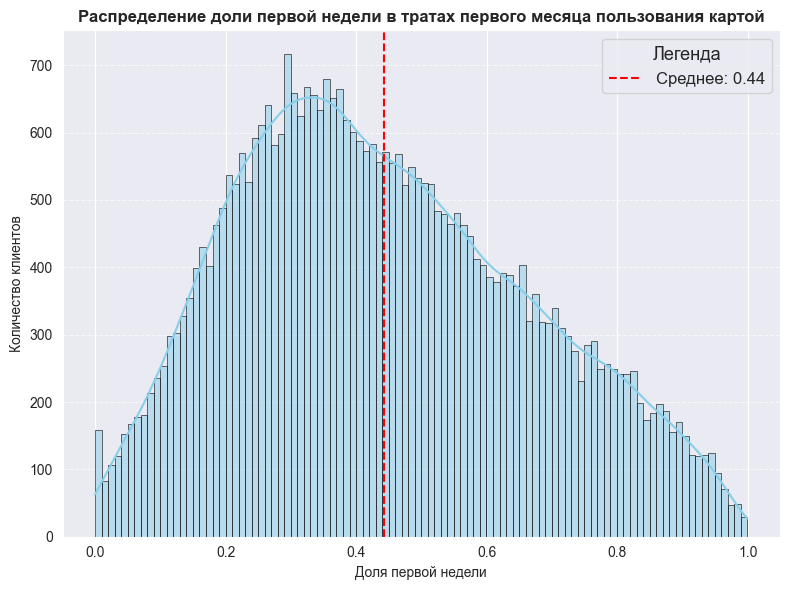

In [38]:
plt.figure(figsize=(8, 6))
sns.histplot(cls[cls < 1], bins=100, kde=True, color='skyblue', edgecolor='black')

plt.title('Распределение доли первой недели в тратах первого месяца пользования картой', fontsize=12, weight='bold')
plt.xlabel('Доля первой недели', fontsize=10)
plt.ylabel('Количество клиентов', fontsize=10)

plt.axvline(m, ymin=0, ymax=700, color='red', linestyle='--', label='Среднее: {:.2f}'.format(m))

plt.legend(title='Легенда', title_fontsize='13', fontsize='12')

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Мы наблюдаем, что среднее значение значительно превышает 0.25, что указывает на то, что траты в первую неделю значительно отличаются от равномерного распределение по неделям в течение первого месяца. Однако данное условие выполняется лишь для 22% клиентов.

In [39]:
s = cls[cls < 1]
print(f'{s[s < 0.25].shape[0] / s.shape[0] * 100:.2f}')

21.66


In [61]:
print(f'Средняя доля первой недели в тратах первого месяца пользования картой: {cls.mean() * 100:.2f} %')
print(f'Средняя доля первой недели в тратах первого месяца пользования картой (без учета прекративших покупки после первой недели): {cls[cls < 1].mean() * 100:.2f} %')

Средняя доля первой недели в тратах первого месяца пользования картой: 55.78 %
Средняя доля первой недели в тратах первого месяца пользования картой (без учета прекративших покупки после первой недели): 44.18 %


In [40]:
points_df = pd.read_csv('purchases.csv', usecols=['client_id', 'transaction_id', 'regular_points_spent', 'express_points_spent', 'purchase_sum'])
points_df = points_df.drop_duplicates()

In [41]:
points_df['points_spent'] = points_df.regular_points_spent + points_df.express_points_spent 

In [42]:
m1 = points_df[points_df.points_spent < 0].purchase_sum.mean()
m2 = points_df[points_df.points_spent == 0].purchase_sum.mean()
m3 = - points_df[points_df.points_spent < 0].points_spent.mean()

In [43]:
print(f'Средний чек при использовании бонусных баллов: {m1:.2f} руб.')
print(f'Средний чек без использовании бонусных баллов: {m2:.2f} руб.')
print(f'Рост среднего чека от использовании бонусных баллов: {m1-m2:.2f} руб. ({(m1/m2-1)*100:.2f} %)')
print(f'Средние затраченные бонусные баллы: {m3:.2f} руб.')

Средний чек при использовании бонусных баллов: 466.71 руб.
Средний чек без использовании бонусных баллов: 425.55 руб.
Рост среднего чека от использовании бонусных баллов: 41.16 руб. (9.67 %)
Средние затраченные бонусные баллы: 63.31 руб.


Можем сделать вывод, что для клиентов в среднем выгодно использование баллов: они при большем чеке тратят меньшую сумму. Следовательно, приобретают больше благ.

На графике представлено распределение покупок в зависимости от использования баллов. Мы видим, что большинство клиентов охотно оплачивают свои покупки суммами до 200 рублей. Однако стоит отметить, что правый хвост распределения для покупок с использованием баллов демонстрирует более выраженный вес. Это означает, что клиенты, использующие баллы, чаще совершают более крупные покупки. Этот бизнес-инсайт указывает на возможность адаптации границы для использования баллов: ее можно смещать в зависимости от ожидаемого поведения клиентов, приближая к нулю или отдаляя от него.

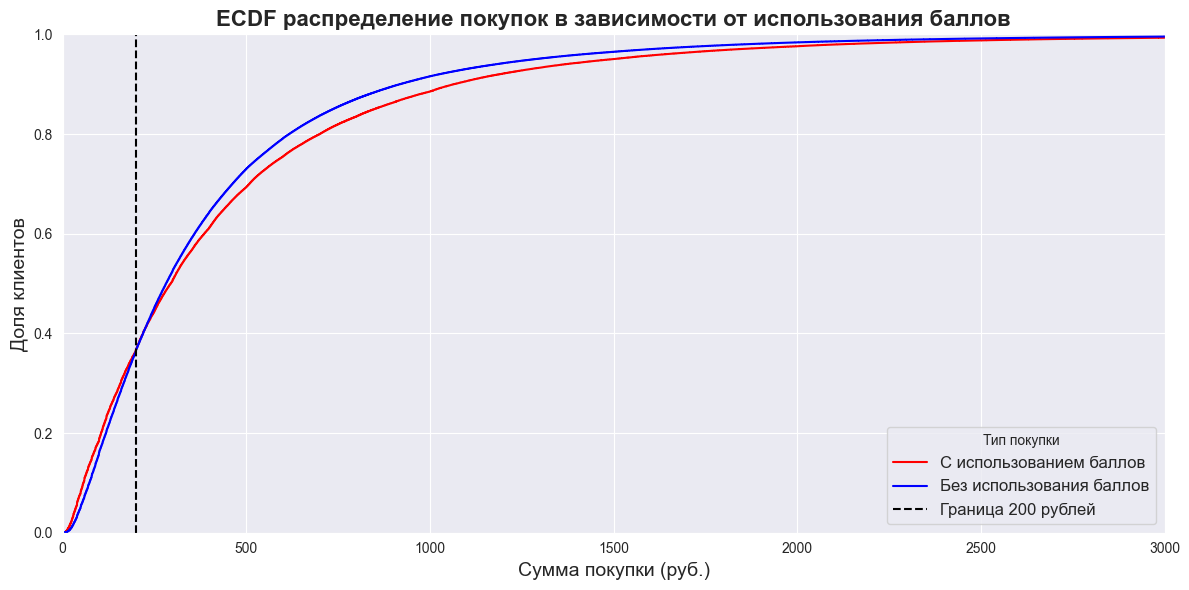

In [45]:
plt.figure(figsize=(12, 6))
sns.ecdfplot(points_df[points_df.points_spent < 0].purchase_sum, color='red', label='С использованием баллов')
sns.ecdfplot(points_df[points_df.points_spent == 0].purchase_sum, color='blue', label='Без использования баллов')

plt.axvline(200, linestyle='--', color='black', label='Граница 200 рублей')

plt.xlim(0, 3000)
plt.title('ECDF распределение покупок в зависимости от использования баллов', fontsize=16, weight='bold')
plt.xlabel('Сумма покупки (руб.)', fontsize=14)
plt.ylabel('Доля клиентов', fontsize=14)
plt.legend(title='Тип покупки', fontsize=12)

plt.tight_layout()
plt.show()

In [104]:
k1 = points_df[points_df.points_spent < 0].purchase_sum.count()
k2 = points_df.purchase_sum.count()
print(f'Доля покупок с использованием бонусных баллов составляет {k1 / k2 * 100:.2f}% от общего числа покупок.')

Доля покупок с использованием бонусных баллов составляет 6.27% от общего числа покупок.


In [46]:
df = pd.merge(purchases[['client_id', 'transaction_id', 'purchase_sum', 'transaction_datetime']], clients[['client_id', 'first_issue_date']], on='client_id', how='left')
df['week_num'] = (df.transaction_datetime - df.first_issue_date).dt.days // 7 + 1
df = df[df.week_num > 0]

In [47]:
df_ = df[['transaction_id', 'week_num']]
points_df_ = pd.merge(points_df[['transaction_id', 'purchase_sum', 'points_spent']], df_, on='transaction_id', how='left')
t1 = points_df_[points_df_.points_spent < 0].groupby('week_num').purchase_sum.sum().reset_index()
t2 = points_df_.groupby('week_num').purchase_sum.sum().reset_index()
t1 = pd.merge(t1, t2, on='week_num', suffixes=['_points', '_total'])
t1['points_partition'] = (t1['purchase_sum_points'] / t1['purchase_sum_total']) * 100
t1.points_partition = t1.points_partition.apply(lambda x: round(x, 2))
nums_examples = points_df_.groupby('week_num').purchase_sum.count()

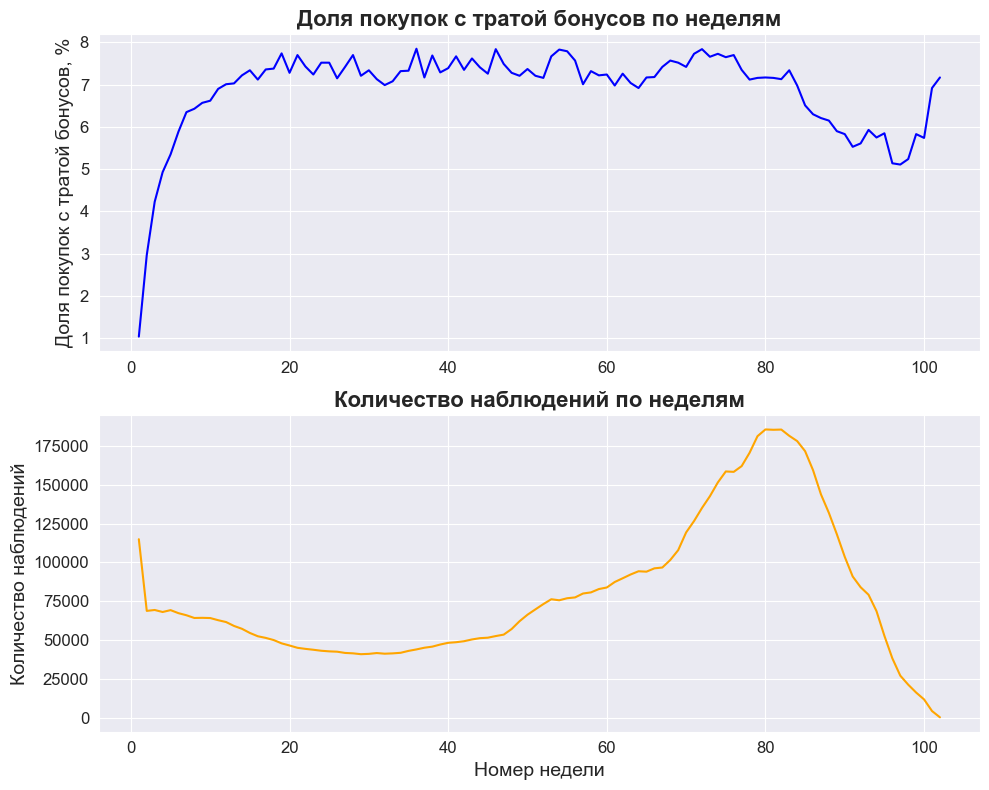

In [50]:
plt.figure(figsize=(10, 8))

plt.subplot(211)
sns.lineplot(data=t1, x='week_num', y='points_partition', color='blue')
plt.title('Доля покупок с тратой бонусов по неделям', fontsize=16, weight='bold')
plt.ylabel('Доля покупок с тратой бонусов, %', fontsize=14)
plt.xlabel('', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

plt.subplot(212)
sns.lineplot(data=nums_examples, color='orange')
plt.title('Количество наблюдений по неделям', fontsize=16, weight='bold')
plt.xlabel('Номер недели', fontsize=14)
plt.ylabel('Количество наблюдений', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

Есть вероятность, что спад после пиковой 80-й недели происходит из-за того, что в нашем датасете мало наблюдений этой группы клиентов.

In [52]:
df = pd.merge(pd.merge(avg_purch, avg_points_expences, on='week_num'), avg_cart, on='week_num')

Видим, что после 70 недели есть рост и среднего чека, и среднего недельного количества покупок.

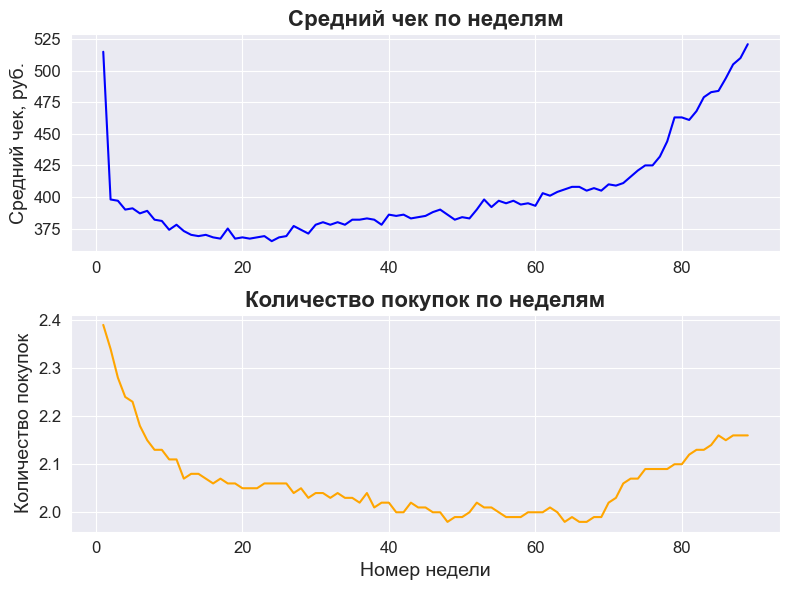

In [55]:
plt.figure(figsize=(8, 6))

plt.subplot(211)
sns.lineplot(data=df[df.week_num < 90], x='week_num', y='avg_check', color='blue')
plt.title('Средний чек по неделям', fontsize=16, weight='bold')
plt.ylabel('Средний чек, руб.', fontsize=14)
plt.xlabel('', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

plt.subplot(212)
sns.lineplot(data=df[df.week_num < 90], x='week_num', y='avg_purch_count', color='orange')
plt.title('Количество покупок по неделям', fontsize=16, weight='bold')
plt.xlabel('Номер недели', fontsize=14)
plt.ylabel('Количество покупок', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()


Используем линейную регрессию для обнаружения тренда временного ряда.

После 70 недели каждая следующая неделя пользования услугами магазина увеличивает средний чек на 1.33 % и на 0.34 % количество покупок в неделю.

In [59]:
print(sm.OLS(np.log(df[(df.week_num >= 70) & (df.week_num < 90)].avg_purch_count), 
    sm.add_constant((df[(df.week_num >= 70) & (df.week_num < 90)].week_num))).fit().summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.946     
Dependent Variable: avg_purch_count  AIC:                -155.0982 
Date:               2024-10-08 15:34 BIC:                -153.1068 
No. Observations:   20               Log-Likelihood:     79.549    
Df Model:           1                F-statistic:        331.0     
Df Residuals:       18               Prob (F-statistic): 4.90e-13  
R-squared:          0.948            Scale:              2.2830e-05
---------------------------------------------------------------------
               Coef.    Std.Err.      t      P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const          0.4766     0.0148   32.2695   0.0000   0.4456   0.5076
week_num       0.0034     0.0002   18.1942   0.0000   0.0030   0.0038
-------------------------------------------------------------------
Omnibus:               0.628         Durbin-Watson:     

Это другая часть из другого файла.

In [60]:
purchases = pd.read_csv('purchases_processed.csv', usecols=['client_id', 'transaction_datetime', 'sum_purchase', 'first_issue_date'])

In [61]:
purchases.head()

,client_id,transaction_datetime,sum_purchase,first_issue_date
0,000012768d,2019-03-08,804,2017-08-05
1,000012768d,2018-12-01,1007,2017-08-05
2,000012768d,2019-03-14,419,2017-08-05
3,000012768d,2018-12-16,575,2017-08-05
4,000036f903,2018-12-21,700,2017-04-10


In [62]:
purchases.transaction_datetime =  pd.to_datetime(purchases.transaction_datetime).dt.date
purchases.first_issue_date =  pd.to_datetime(purchases.first_issue_date).dt.date
purchases['days'] = ((purchases.transaction_datetime - purchases.first_issue_date) / datetime.timedelta(days=1)).astype(int)
purchases['weeks'] = purchases['days'] // 7 + 1
purchases = purchases.groupby(['client_id', 'transaction_datetime', 'weeks']).agg({'sum_purchase': 'sum'}).reset_index()

In [63]:
purchases.head()

,client_id,transaction_datetime,weeks,sum_purchase
0,000012768d,2018-12-01,70,1007
1,000012768d,2018-12-16,72,575
2,000012768d,2019-03-08,83,804
3,000012768d,2019-03-14,84,419
4,000036f903,2018-11-28,86,241


Ранее был создан столбец weeks, в котором минимальным значением ожидается 1. Но мы можем видеть, что в данных встречаются клиенты, которые совершали покупки "до" оформления карты. Таких записей немного, поэтому можем их исключить.

In [64]:
purchases[purchases.weeks == 0].shape[0]

34

In [65]:
purchases = purchases[purchases.weeks > 0].reset_index(drop=True)

In [66]:
clients = pd.read_csv('clients.csv', usecols=['client_id', 'first_issue_date', 'age', 'gender'])
clients.first_issue_date = pd.to_datetime(clients.first_issue_date).dt.date

In [67]:
clients.head()

,client_id,first_issue_date,age,gender
0,000012768d,2017-08-05,45,U
1,000036f903,2017-04-10,72,F
2,000048b7a6,2018-12-15,68,F
3,000073194a,2017-05-23,60,F
4,00007c7133,2017-05-22,67,U


In [68]:
table = purchases.groupby('weeks').agg({'sum_purchase': ['mean', 'count', 'std']}).reset_index()
table.columns = ['weeks', 'avg_purchase', 'num_of_observation', 'std_purchase']

Посмотрим на общую картину трат пользователей по неделям.

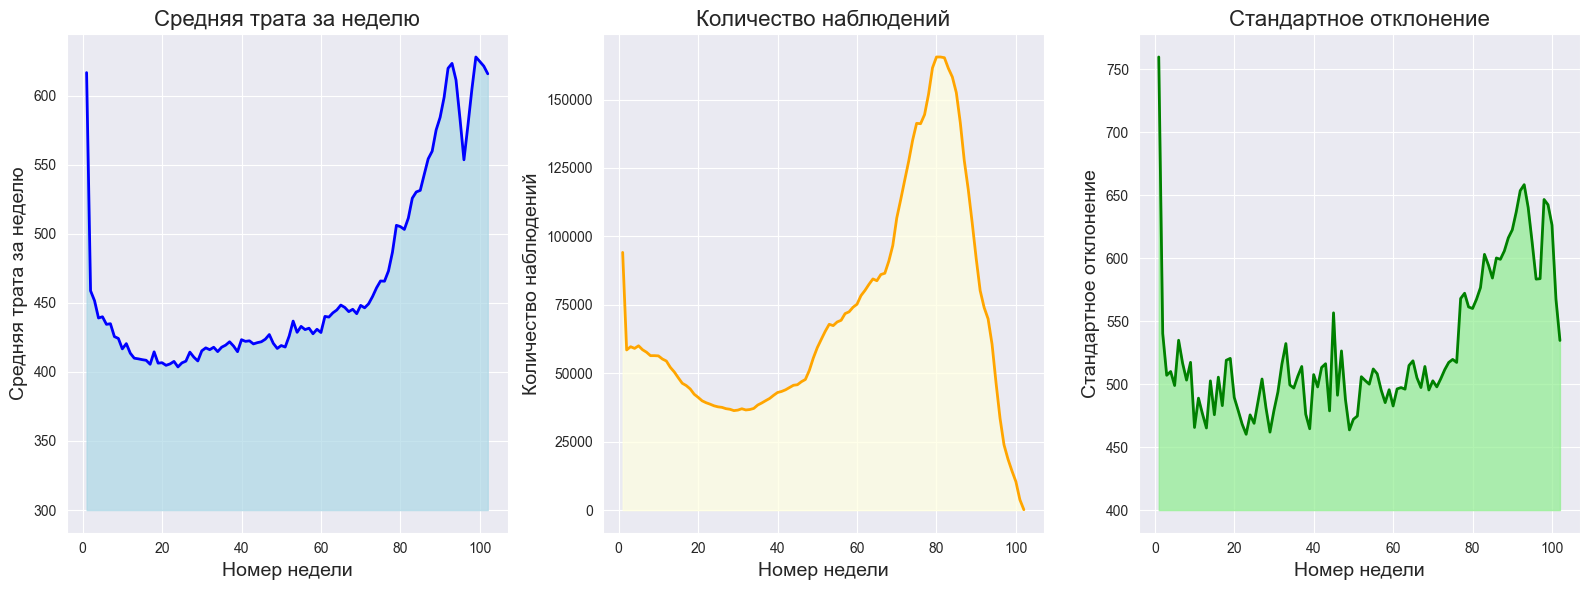

In [71]:
plt.figure(figsize=(16, 6))
sns.set_palette('muted')
sns.set_style("darkgrid")

# График 1: Средняя трата за неделю
plt.subplot(131)
sns.lineplot(data=table, x='weeks', y='avg_purchase', color='blue', linewidth=2)
plt.fill_between(table.weeks, table.avg_purchase, 300, color='lightblue', alpha=0.7)
plt.xlabel('Номер недели', fontsize=14)
plt.ylabel('Средняя трата за неделю', fontsize=14)
plt.title('Средняя трата за неделю', fontsize=16)

# График 2: Количество наблюдений
plt.subplot(132)
sns.lineplot(data=table, x='weeks', y='num_of_observation', color='orange', linewidth=2)
plt.fill_between(table.weeks, table.num_of_observation, color='lightyellow', alpha=0.7)
plt.xlabel('Номер недели', fontsize=14)
plt.ylabel('Количество наблюдений', fontsize=14)
plt.title('Количество наблюдений', fontsize=16)

# График 3: Стандартное отклонение
plt.subplot(133)
sns.lineplot(data=table, x='weeks', y='std_purchase', color='green', linewidth=2)
plt.fill_between(table.weeks, table.std_purchase, 400, color='lightgreen', alpha=0.7)
plt.xlabel('Номер недели', fontsize=14)
plt.ylabel('Стандартное отклонение', fontsize=14)
plt.title('Стандартное отклонение', fontsize=16)

plt.tight_layout()
plt.show()

Для клиентов, достигших 90-й недели использования, фиксируется снижение количества наблюдений и увеличение стандартного отклонения. Для 80-й недели зафиксировано максимальное количество наблюдений, при этом стандартное отклонение также превышает обычный уровень, но не так значительно. В то же время отмечается существенный рост средних недельных трат.

In [72]:
x1 = purchases[purchases.sum_purchase > 1000].groupby('weeks').agg({'sum_purchase': ['count']}).reset_index()
x1.columns = ['weeks', 'big_purch']
x2 = purchases.groupby('weeks').agg({'sum_purchase': ['count']}).reset_index()
x2.columns = ['weeks', 'all_purch']
x1 = pd.merge(x1, x2, on='weeks')
x1['big_purch_ratio'] = x1['big_purch'] / x1['all_purch']

In [73]:
purchases_a = purchases[['client_id', 'weeks']]
x_arr_count = []
counter_arr = []
for i in range(1, 91):
    t1 = purchases_a[(purchases_a.weeks == i)]
    t2 = purchases_a[(purchases_a.weeks == i+1)]
    x = pd.merge(t1, t2, on='client_id', how='left')
    counter_arr.append(x.iloc[:, 2].isna().sum() / x.shape[0])
    x_arr_count.append(i)

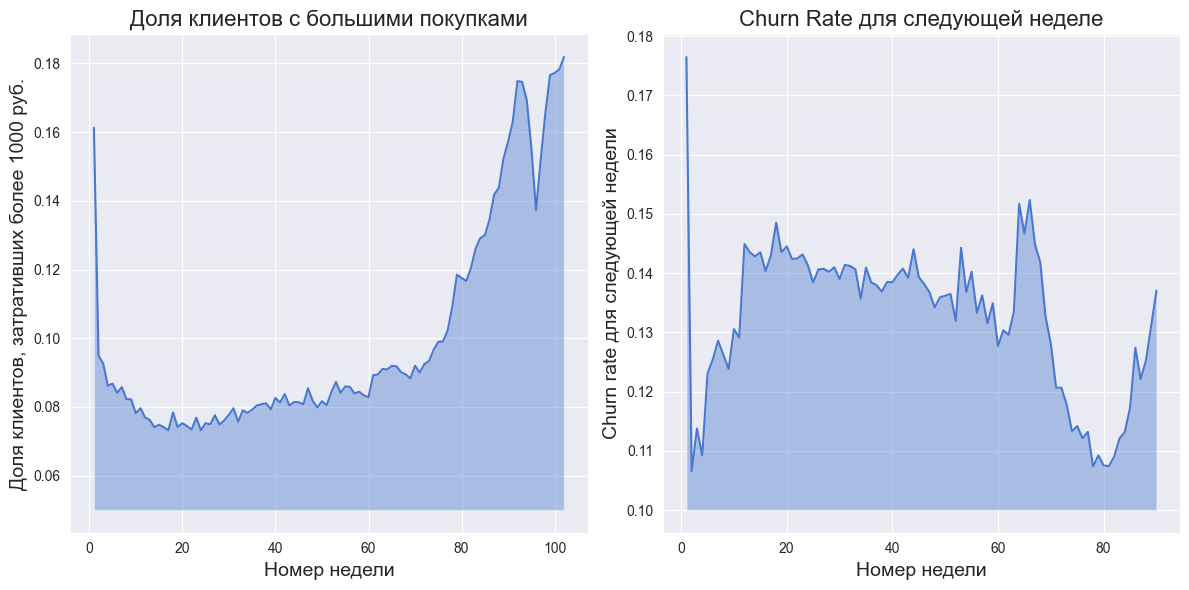

In [80]:
plt.figure(figsize=(12, 6))
sns.set_palette(palette='muted')
sns.set_style("darkgrid")
plt.subplot(121)
sns.lineplot(x1, x='weeks', y='big_purch_ratio')
plt.fill_between(x1.weeks, x1.big_purch_ratio, 0.05, alpha=0.4)
plt.xlabel('Номер недели', fontsize=14)
plt.ylabel('Доля клиентов, затративших более 1000 руб.', fontsize=14)
plt.title('Доля клиентов с большими покупками', fontsize=16)
plt.subplot(122)
sns.lineplot(x=x_arr_count, y=counter_arr)
plt.fill_between(x_arr_count, counter_arr, 0.1, alpha=0.4)
plt.xlabel('Номер недели', fontsize=14)
plt.ylabel('Churn rate для следующей недели', fontsize=14)
plt.title('Churn Rate для следующей неделе', fontsize=16)

plt.tight_layout()
plt.show()

In [76]:
purchases_a = purchases[['client_id', 'weeks']]
x_arr_count_m = []
counter_arr_m = []
for i in range(1, 91):
    t1 = set(purchases_a[(purchases_a.weeks == i)].client_id.tolist())
    t2 = set(purchases_a[(purchases_a.weeks >= i+1) & (purchases_a.weeks <= i+4)].client_id.tolist())
    counter_arr_m.append(len(t1.intersection(t2)) / len(t1))
    x_arr_count_m.append(i)

In [88]:
counter_arr_m = 1-np.array(counter_arr_m)

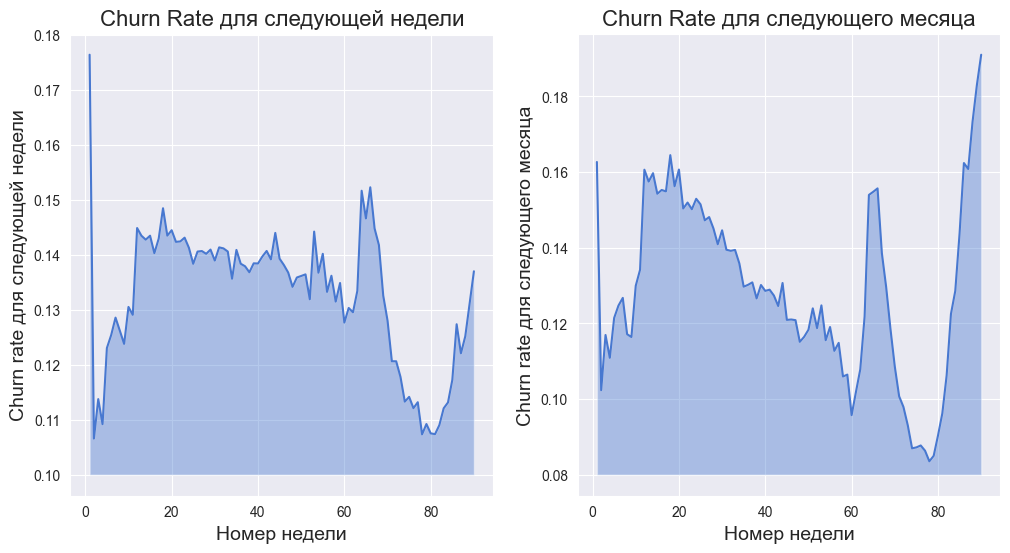

In [91]:
plt.figure(figsize=(12, 6))
sns.set_palette(palette='muted')
sns.set_style("darkgrid")

plt.subplot(121)
sns.lineplot(x=x_arr_count, y=counter_arr)
plt.fill_between(x_arr_count, counter_arr, 0.1, alpha=0.4)
plt.xlabel('Номер недели', fontsize=14)
plt.ylabel('Churn rate для следующей недели', fontsize=14)
plt.title('Churn Rate для следующей недели', fontsize=16)

plt.subplot(122)
sns.lineplot(x=x_arr_count_m, y=counter_arr_m)
plt.fill_between(x_arr_count_m, counter_arr_m, 0.08, alpha=0.4)
plt.xlabel('Номер недели', fontsize=14)
plt.ylabel('Churn rate для следующего месяца', fontsize=14)
plt.title('Churn Rate для следующего месяца', fontsize=16)

plt.show()

Видим аномалию в районе 70-й недели. Почему-то клиенты демонстрируют высокий уровень оттока, затем он снова понижается, достигая минимума на 80-й неделе. Вероятно, он продолжает данную тенденцию, но данных по клиентам нет. 

Как мы видели ранее, самые преданные клиенты тратят больше. Также много тратят самые новые клиенты. Клиенты, оформившие карту больше 70 недель назад, в среднем тратят намного больше, тем более видим резкий рост. Выдвинем гипотезу: клиенты после 70 недели увеличивают средние траты, при этом клиенты, тратившие ниже среднего в предыдущие недели, перестают пользоваться услугами.

In [93]:
part_of_weeks = purchases.groupby('weeks').sum_purchase.sum().reset_index()
part_of_weeks.columns = ['weeks', 'sum_purchase']

In [94]:
bins = [0, 4, 10, 30, 50, 70, 90, np.inf]
labels = ['1-4', '5-10', '11-30', '31-50', '51-70', '71-90', '91+']
part_of_weeks['categories'] = pd.cut(part_of_weeks['weeks'], bins=bins, labels=labels, right=True)
groups_impact = part_of_weeks.groupby('categories', observed=True).sum_purchase.sum().reset_index()
groups_impact['ratio'] = groups_impact.sum_purchase / groups_impact.sum_purchase.sum() *100

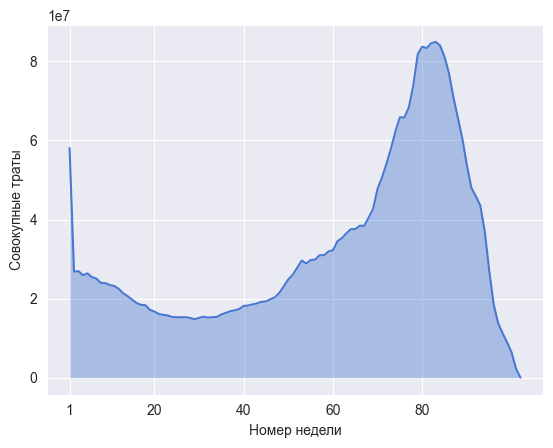

In [95]:
sns.lineplot(part_of_weeks, x='weeks', y='sum_purchase')
plt.xlabel('Номер недели')
plt.ylabel('Совокупные траты')
plt.fill_between(part_of_weeks.weeks, part_of_weeks.sum_purchase, alpha=0.4)
plt.xticks([1, 20, 40, 60, 80])
plt.show()

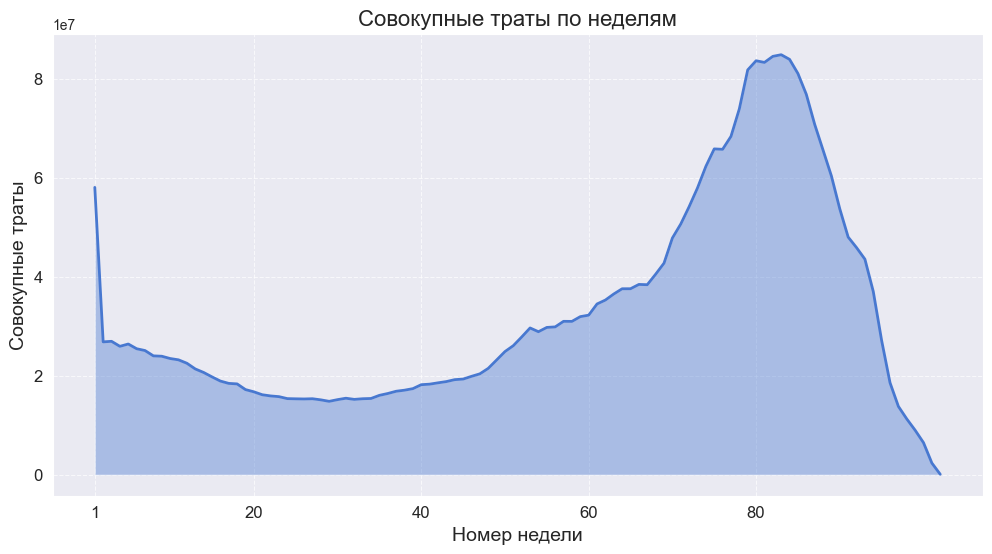

In [97]:
plt.figure(figsize=(12, 6))
sns.lineplot(part_of_weeks, x='weeks', y='sum_purchase', linewidth=2)
plt.fill_between(part_of_weeks.weeks, part_of_weeks.sum_purchase, alpha=0.4)
plt.xlabel('Номер недели', fontsize=14)
plt.ylabel('Совокупные траты', fontsize=14)
plt.title('Совокупные траты по неделям', fontsize=16)
plt.xticks([1, 20, 40, 60, 80], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


Можем видеть, что клиенты, использующие карту от 70 до 90 недели вносят наибольший вклад в выручку компании.

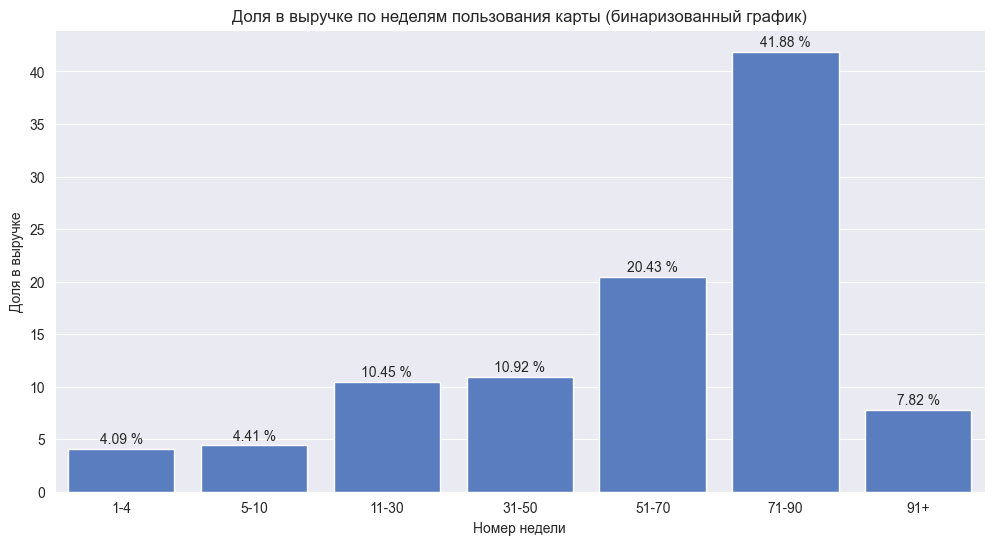

In [100]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(groups_impact, x='categories', y='ratio')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.5, f'{p.get_height():.2f} %',ha='center')
plt.xlabel('Номер недели')
plt.ylabel('Доля в выручке')
plt.title('Доля в выручке по неделям пользования карты (бинаризованный график)')
plt.show()

In [101]:
clients_by_weeks = purchases.groupby('weeks').client_id.nunique().reset_index()
labels = ['1-4', '5-10', '11-30', '31-50', '51-70', '71-90', '91+']
clients_by_weeks['categories'] = pd.cut(clients_by_weeks['weeks'], bins=bins, labels=labels, right=True)
cls_groups_impact = clients_by_weeks.groupby('categories', observed=True).client_id.sum().reset_index()
cls_groups_impact['ratio'] = cls_groups_impact.client_id / cls_groups_impact.client_id.sum() * 100

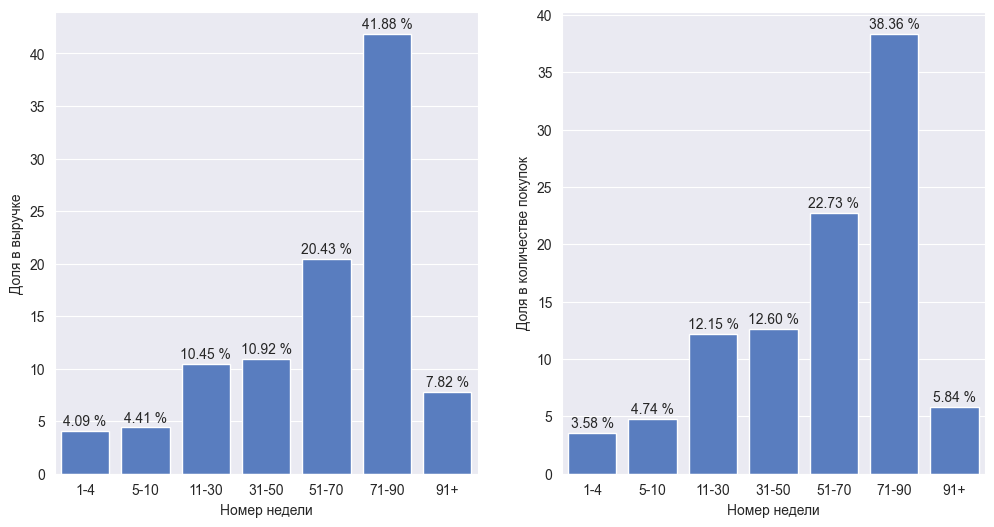

In [102]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
ax = sns.barplot(groups_impact, x='categories', y='ratio')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.5, f'{p.get_height():.2f} %',ha='center')
plt.xlabel('Номер недели')
plt.ylabel('Доля в выручке')
plt.subplot(122)
ax = sns.barplot(cls_groups_impact, x='categories', y='ratio')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.5, f'{p.get_height():.2f} %',ha='center')
plt.xlabel('Номер недели')
plt.ylabel('Доля в количестве покупок')
plt.show()

На иллюстрации мы еще раз можем видеть, что группа от 71 до 90 недели вносит вклад не только числом покупателей, но и их "весом". 

In [103]:
purch = purchases.copy()

In [104]:
clients_70 = purchases[purchases.weeks == 70].client_id.unique()
purch['weeks_to_end'] = ((purch.transaction_datetime.max() - purch.transaction_datetime) / datetime.timedelta(days=1)).astype(int) + 1
purch70 = purch[(purch.weeks > 70) & (purch.weeks <= 80) & (purch.client_id.isin(clients_70) & (purch.weeks_to_end >= 10))]
churn = purch70.groupby('weeks').client_id.count()

In [108]:
churn

weeks
71    76207
72    71173
73    67296
74    64166
75    60524
76    56338
77    54840
78    51797
79    48633
80    44362
Name: client_id, dtype: int64

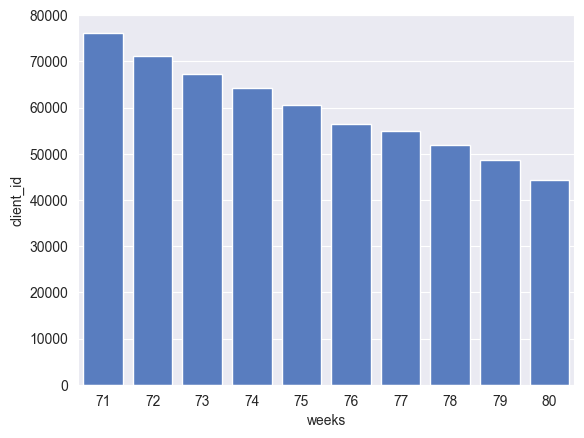

In [105]:
sns.barplot(churn)
plt.show()

На графика видно, что с каждой неделей наблюдается устойчивое снижение показателя оттока клиентов, которые прекратили пользоваться услугами на срок 10 и более недель. Это может свидетельствовать о том, что клиентская база становится более стабильной, а уровень удержания клиентов со временем растет. Возможно, внедрение дополнительных мер по удержанию клиентов или улучшение качества услуг способствовало снижению оттока в долгосрочной перспективе.

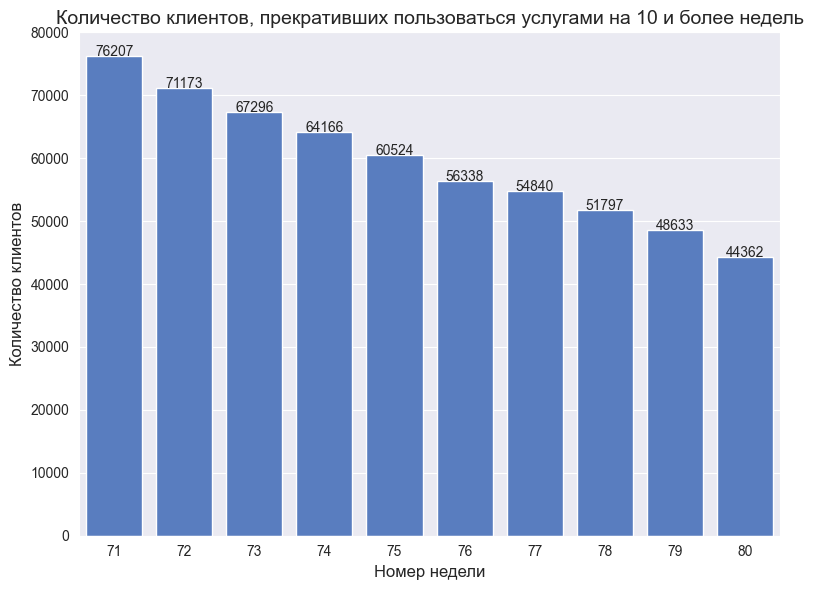

In [111]:
churn_df = churn.reset_index()
churn_df.columns = ['week_num', 'churn_count']

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=churn_df, x='week_num', y='churn_count')
plt.title('Количество клиентов, прекративших пользоваться услугами на 10 и более недель', fontsize=14)
plt.xlabel('Номер недели', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.5, f'{int(p.get_height())}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [112]:
begin = 20
size = 10

clients_ind = purchases[purchases.weeks == begin].client_id.unique()
purch['weeks_to_end'] = ((purch.transaction_datetime.max() - purch.transaction_datetime) / datetime.timedelta(days=1)).astype(int) + 1
purch_ind = purch[(purch.weeks > begin) & (purch.weeks <= begin + size) & (purch.client_id.isin(clients_ind) & (purch.weeks_to_end >= size))]
churn = purch_ind.groupby('weeks').client_id.count()

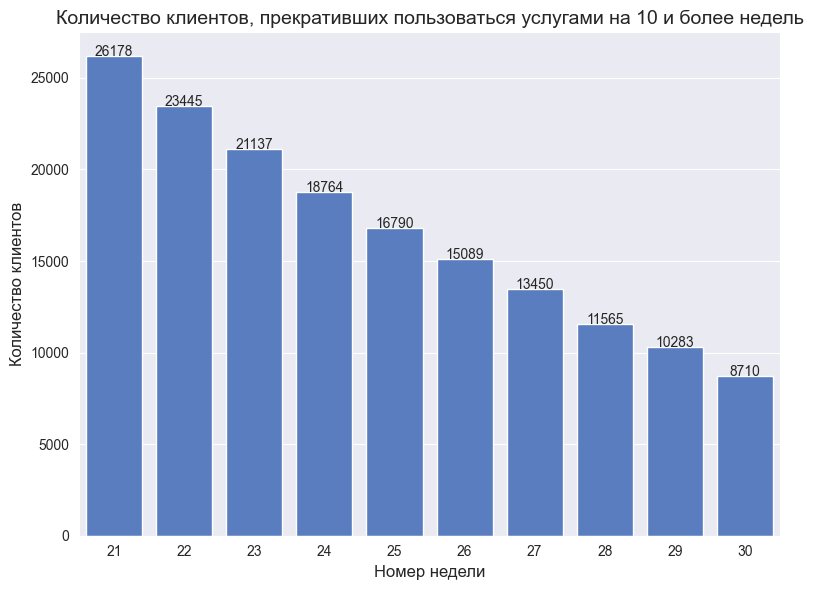

In [114]:
churn_df = churn.reset_index()
churn_df.columns = ['week_num', 'churn_count']

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=churn_df, x='week_num', y='churn_count')
plt.title('Количество клиентов, прекративших пользоваться услугами на 10 и более недель', fontsize=14)
plt.xlabel('Номер недели', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.5, f'{int(p.get_height())}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

Видим, что для 21-30 недель резко снижается такой показатель, что свидетельствует о том, что клиенты становятся более лояльными в долгосрочной перспективе, при этом, как мы видели ранее, в краткосрочной перспективе данные клиенты тратят не так много и могут перестать пользоваться картой лояльности на длительное время.

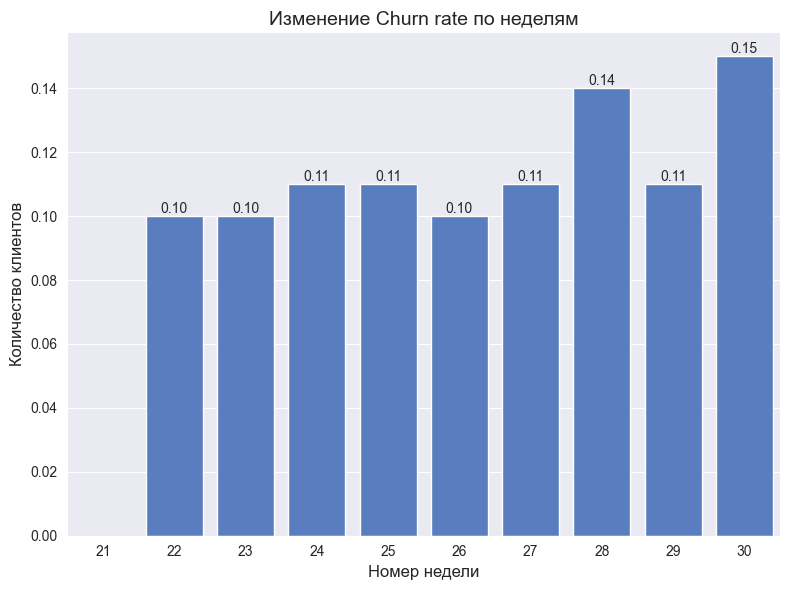

In [137]:
churn_ = np.round(1 - churn / churn.shift(1), 2)
churn_df = churn_.reset_index()
churn_df.columns = ['week_num', 'churn_count']

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=churn_df, x='week_num', y='churn_count')
plt.title('Изменение Churn rate по неделям', fontsize=14)
plt.xlabel('Номер недели', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.001, f'{p.get_height():.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [138]:
begin = 70
size = 10

clients_ind = purchases[purchases.weeks == begin].client_id.unique()
purch['weeks_to_end'] = ((purch.transaction_datetime.max() - purch.transaction_datetime) / datetime.timedelta(days=1)).astype(int) + 1
purch_ind = purch[(purch.weeks > begin) & (purch.weeks <= begin + size) & (purch.client_id.isin(clients_ind) & (purch.weeks_to_end >= size))]
churn = purch_ind.groupby('weeks').client_id.count()

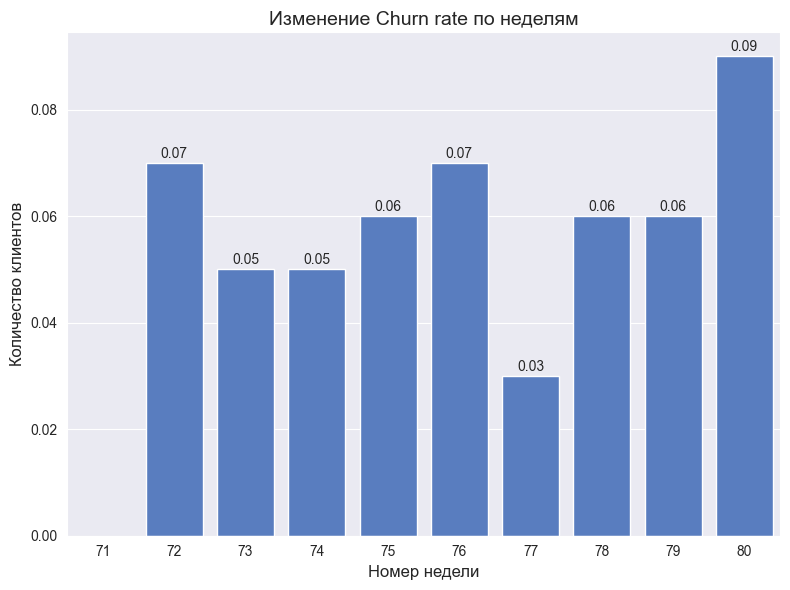

In [139]:
churn_ = np.round(1 - churn / churn.shift(1), 2)
churn_df = churn_.reset_index()
churn_df.columns = ['week_num', 'churn_count']

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=churn_df, x='week_num', y='churn_count')
plt.title('Изменение Churn rate по неделям', fontsize=14)
plt.xlabel('Номер недели', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.001, f'{p.get_height():.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

Видим, что для клиентов с большим количеством недель Churn rate колеблется намного меньше, что говорит о большей стабильности и постоянстве.

In [140]:
merged = pd.merge(clients[['client_id']], 
                  purchases[['client_id', 'weeks', 'sum_purchase']], 
                  on='client_id', how='left')

In [141]:
merged.head()

,client_id,weeks,sum_purchase
0,000012768d,70,1007
1,000012768d,72,575
2,000012768d,83,804
3,000012768d,84,419
4,000036f903,86,241


Всего в наших наблюдениях покупок более 16 недель. Значит, для каждого клиента, который совершал покупки на 70-ую неделю, мы можем проследить дальнейшую историю: он мог прекратить покупки совсем, не покупать в некоторые из недель или, наоборот, увеличить недельные траты.

In [143]:
print(int((purchases.transaction_datetime.max() - purchases.transaction_datetime.min()).days / 7))

16


Границы наблюдаемого периода выглядят так.

In [144]:
print(purchases.transaction_datetime.min(), purchases.transaction_datetime.max())

2018-11-21 2019-03-18


Отсортируем только тех клиентов, для которых с 70 по 79 неделю целиком попали на выбранный промежуток.

In [145]:
clnts = clients[(clients.first_issue_date >= purchases.transaction_datetime.min() - pd.Timedelta(days=69*7)) &
                (clients.first_issue_date <= purchases.transaction_datetime.max() - pd.Timedelta(days=10*7))].client_id.tolist()

# Посчитаем количество клиентов
print(len(clnts))

270191


Выборка остается внушительной. Посмотрим, сколько из них не совершили ни одной покупки на данном временном интервале.

In [146]:
purchases.client_id[purchases.client_id.isin(clnts)].nunique()

270191

Таких не оказалось. Будем честны, но в реальности, на более полных данных мы бы обнаружили много таких клиентов. Будем держать в голове мысль о смещенности выборки, однако большое количество наблюдений может помочь асимптотически прийти к правильным выводам.

In [147]:
clnts_df = clients[['client_id', 'first_issue_date']][clients.client_id.isin(clnts)]

In [148]:
olds = pd.merge(clnts_df, purchases[['client_id', 'transaction_datetime', 'sum_purchase']], on='client_id', how='left')
olds['weeks'] = ((pd.to_datetime(olds.transaction_datetime) - pd.to_datetime(olds.first_issue_date)).dt.days / 7).astype(int) + 1
olds = olds[['client_id', 'weeks', 'sum_purchase']]
olds = olds[(olds.weeks >= 70) & (olds.weeks <= 79)]

In [ ]:
olds.head()

,client_id,weeks,sum_purchase
0,000012768d,70,1007
1,000012768d,72,575
20,00007f9014,70,376
21,00007f9014,71,282
22,00007f9014,71,227


In [149]:
olds = olds.groupby(['client_id', 'weeks']).sum_purchase.sum().reset_index()

In [150]:
olds = pd.pivot(olds, index='client_id', columns='weeks', values='sum_purchase').fillna(0).astype(int).reset_index()

Видим, что нулей достаточно много.

In [ ]:
olds.head()

weeks,client_id,70,71,72,73,74,75,76,77,78,79
0,000012768d,1007,0,575,0,0,0,0,0,0,0
1,00007f9014,376,509,1033,0,0,200,0,110,1054,758
2,0002ce2217,0,0,129,0,223,0,0,0,562,131
3,00042a927a,0,0,307,766,1314,0,0,0,0,0
4,0005ce475d,538,1825,3530,470,1000,1759,0,389,341,1296


In [151]:
weeks_ = olds.columns.tolist()[1:]
olds = pd.melt(olds, id_vars=['client_id'], value_vars=weeks_, value_name='purchase_sum')

In [152]:
weeks_nums = pd.merge(olds[olds.purchase_sum > 0].groupby('weeks').purchase_sum.count().reset_index(), 
    olds.groupby('weeks').purchase_sum.count().reset_index(), on='weeks')
weeks_nums.columns = ['weeks', 'notnull', 'total']
weeks_nums['normal_clients'] = weeks_nums['notnull'] / weeks_nums['total']

Доля клиентов, потративших более 0 рублей, уменьшается на 2 процента с каждой неделей.

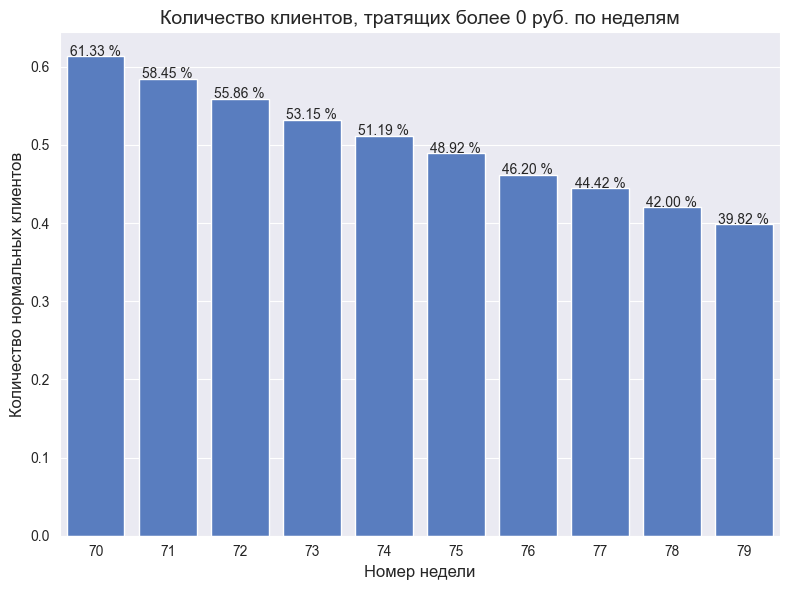

In [162]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=weeks_nums, x='weeks', y='normal_clients')
plt.title('Количество клиентов, тратящих более 0 руб. по неделям', fontsize=14)
plt.xlabel('Номер недели', fontsize=12)
plt.ylabel('Количество нормальных клиентов', fontsize=12)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.001, f'{p.get_height() * 100:.2f} %', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

Возьмем за базовую неделю 70-ую. Рассмотрим только тех клиентов, которые потратили на 70-й неделе некоторую сумму.

In [163]:
lst_of_cls = olds[(olds.purchase_sum > 0) & (olds.weeks == 70)].client_id.tolist()
cls70 = olds[olds.client_id.isin(lst_of_cls)]

In [164]:
weeks_nums = pd.merge(cls70[cls70.purchase_sum > 0].groupby('weeks').purchase_sum.count().reset_index(), 
    cls70.groupby('weeks').purchase_sum.count().reset_index(), on='weeks')
weeks_nums.columns = ['weeks', 'notnull', 'total']
weeks_nums['normal_clients'] = weeks_nums['notnull'] / weeks_nums['total']

Видим резкое падение после 70-й недели. Это означает, что retention rate для данной группы чуть более 0.6, для большего временного окна снижается на те же 2 процента в неделю.

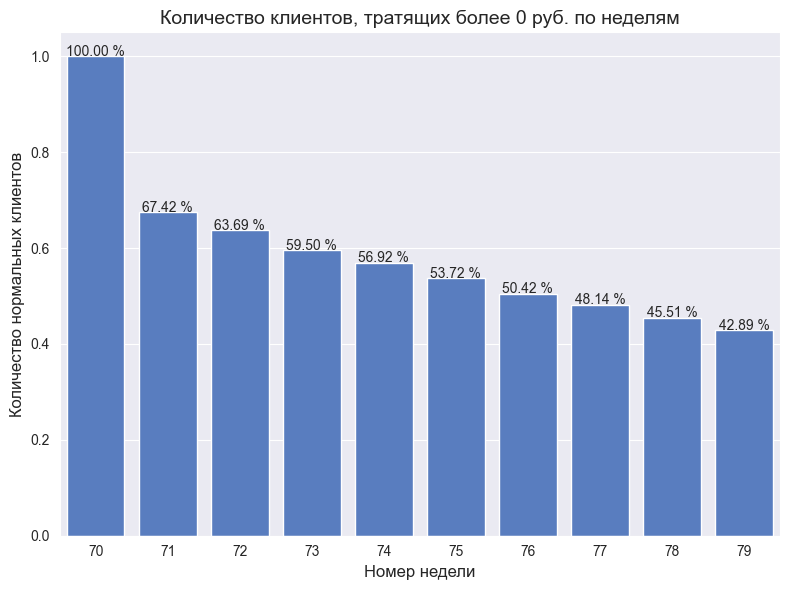

In [166]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=weeks_nums, x='weeks', y='normal_clients')
plt.title('Количество клиентов, тратящих более 0 руб. по неделям', fontsize=14)
plt.xlabel('Номер недели', fontsize=12)
plt.ylabel('Количество нормальных клиентов', fontsize=12)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.001, f'{p.get_height() * 100:.2f} %', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

In [167]:
lst = olds[(olds.weeks == 70) & (olds.purchase_sum > 0)].client_id.tolist()
mean_by_weeks_nozero = olds[olds.client_id.isin(lst) & (olds.purchase_sum > 0)].groupby('weeks').purchase_sum.mean().reset_index()
mean_by_weeks = olds.groupby('weeks').purchase_sum.mean().reset_index()

Чисто визуально мы видим тренд: среднее значение трат покупателя снижается, но основано это на том, что некоторые клиенты просто перестают пользоваться услугами магазина. Другой тренд состоит в том, что верные компании клиенты тратят в среднем тратят больше, чем прежде, или, по крайней мере не меньше. Мы можем проверить эти изменения t-тестом.

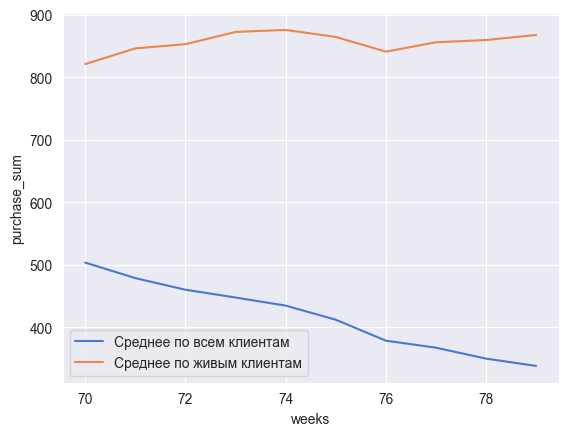

In [ ]:
sns.lineplot(mean_by_weeks, x='weeks', y='purchase_sum', label='Среднее по всем клиентам')
sns.lineplot(mean_by_weeks_nozero, x='weeks', y='purchase_sum', label='Среднее по живым клиентам')
plt.show()

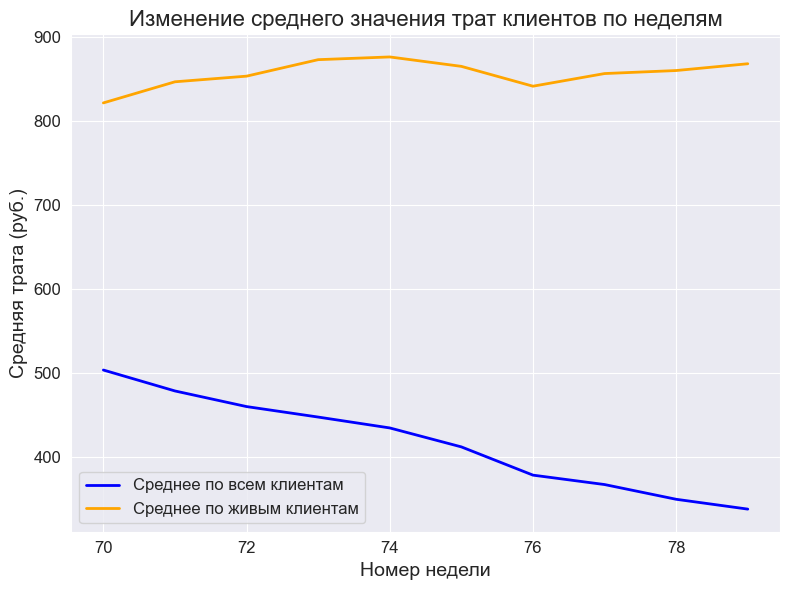

In [171]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=mean_by_weeks, x='weeks', 
             y='purchase_sum', label='Среднее по всем клиентам', linewidth=2, color='blue')
sns.lineplot(data=mean_by_weeks_nozero, x='weeks', 
             y='purchase_sum', label='Среднее по живым клиентам', linewidth=2, color='orange')
plt.title('Изменение среднего значения трат клиентов по неделям', fontsize=16)
plt.xlabel('Номер недели', fontsize=14)
plt.ylabel('Средняя трата (руб.)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [172]:
active_clients = olds[olds.client_id.isin(lst) & (olds.purchase_sum > 0)]

In [173]:
for i in range(10):
    if ttest_ind(active_clients[active_clients.weeks == 70+i].purchase_sum, 
              active_clients[active_clients.weeks == 71+i].purchase_sum, alternative='less').pvalue < 0.05:
        print(f'Наблюдается рост средней суммы между {70+i} и {71+i} неделями')
    else:
        print(f'Не наблюдается рост средней суммы между {70+i} и {71+i} неделями')

Наблюдается рост средней суммы между 70 и 71 неделями
Не наблюдается рост средней суммы между 71 и 72 неделями
Наблюдается рост средней суммы между 72 и 73 неделями
Не наблюдается рост средней суммы между 73 и 74 неделями
Не наблюдается рост средней суммы между 74 и 75 неделями
Не наблюдается рост средней суммы между 75 и 76 неделями
Наблюдается рост средней суммы между 76 и 77 неделями
Не наблюдается рост средней суммы между 77 и 78 неделями
Не наблюдается рост средней суммы между 78 и 79 неделями
Не наблюдается рост средней суммы между 79 и 80 неделями


Статистически значимо мы можем сказать, что лишь в некоторые недели происходит рост средней суммы трат.

Если задать вопрос о том, изменилась ли за 10 недель средняя потраченная сумма, то ответ будет положительным.

In [174]:
if ttest_ind(active_clients[active_clients.weeks == 70].purchase_sum, 
              active_clients[active_clients.weeks == 79].purchase_sum, alternative='less').pvalue < 0.05:
        print(f'Наблюдается рост средней суммы между 70 и 79 неделями')
else:
        print(f'Не наблюдается рост средней суммы между 70 и 79 неделями')

Наблюдается рост средней суммы между 70 и 79 неделями


Поэтому мы можем сказать, что выдвинутая прежде гипотеза подтвердилась: действительно, рост средней потраченной суммы происходит, в основном, за счет того, что старые клиенты тратят больше, чем прежде. Рост незначительный, на некоторых промежутках не распознается как статистически значимый. Стоит отметить, что наблюдаемый эффект может быть вызван общим ростом уровня цен, инфляцией.

Рассмотрим клиентов, которые тратили на 70-й неделе, а затем стали "мертвыми". Как это связано с потраченной суммой и их половозрастными характеристиками.

In [175]:
purch.head()

,client_id,transaction_datetime,weeks,sum_purchase,weeks_to_end
0,000012768d,2018-12-01,70,1007,108
1,000012768d,2018-12-16,72,575,93
2,000012768d,2019-03-08,83,804,11
3,000012768d,2019-03-14,84,419,5
4,000036f903,2018-11-28,86,241,111


In [176]:
research_group = set(purch[(purch.sum_purchase > 0) & (purch.weeks == 70)].client_id) - set(purch[(purch.sum_purchase > 0) & (purch.weeks > 70)].client_id)

In [177]:
research_df = clients[clients.client_id.isin(research_group)][['client_id', 'age', 'gender']]
research_df2 = purch[(purch.client_id.isin(research_group)) & (purch.weeks == 70)][['client_id', 'sum_purchase']]
research_df = pd.merge(research_df, research_df2, on='client_id', how='outer')
research_df = research_df[(research_df.age > 0) & (research_df.age < 100)]

In [178]:
research_df.head()

,client_id,age,gender,sum_purchase
0,0036546652,43,U,1100
1,0041cc521b,47,U,99
2,0047ad7b53,43,U,451
3,004a0adcfb,71,U,910
4,004f98c1b4,36,F,703


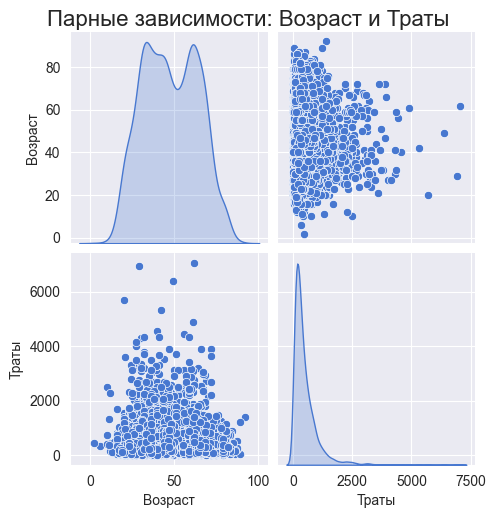

In [183]:
pairplot = sns.pairplot(research_df[['age', 'sum_purchase']].rename({'age': 'Возраст', 'sum_purchase': "Траты"}, axis=1), 
                         diag_kind='kde')
plt.suptitle('Парные зависимости: Возраст и Траты', y=1.02, fontsize=16)
plt.xlabel('Возраст', fontsize=12)
plt.ylabel('Траты', fontsize=12)
plt.show()

In [184]:
control_df = clients[~clients.client_id.isin(research_group)][['client_id', 'age', 'gender']]
control_df2 = purch[(~purch.client_id.isin(research_group)) & (purch.weeks == 70)][['client_id', 'sum_purchase']]
control_df = pd.merge(control_df, control_df2, on='client_id', how='right')
control_df = control_df[(control_df.age > 0) & (control_df.age < 100)]

research_df = research_df.iloc[:, 1:]
research_df = pd.get_dummies(research_df, columns=['gender'], drop_first=True, dtype=int)
research_df = sm.add_constant(research_df)

control_df = control_df.iloc[:, 1:]
control_df = pd.get_dummies(control_df, columns=['gender'], drop_first=True, dtype=int)
control_df = sm.add_constant(control_df)

control_df['target'] = 0
research_df['target'] = 1

In [185]:
X = pd.concat((control_df, research_df), axis=0)
y = X.target
X.drop(['target'], axis=1, inplace=True)

In [186]:
model = sm.Logit(y, X).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.229007
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               106421
Model:                          Logit   Df Residuals:                   106416
Method:                           MLE   Df Model:                            4
Date:                Tue, 08 Oct 2024   Pseudo R-squ.:                0.001533
Time:                        16:29:15   Log-Likelihood:                -24371.
converged:                       True   LL-Null:                       -24409.
Covariance Type:            nonrobust   LLR p-value:                 2.153e-15
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.8503      0.047    -60.222      0.000      -2.943      -2.758
age             -0.0007

In [187]:
X_tranformed = X.copy()
X_tranformed['age**2'] = X_tranformed.age ** 2
X_tranformed['sum_purchase**2'] = X_tranformed.sum_purchase ** 2

In [188]:
model = sm.Logit(y, X_tranformed).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.228689
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               106421
Model:                          Logit   Df Residuals:                   106414
Method:                           MLE   Df Model:                            6
Date:                Tue, 08 Oct 2024   Pseudo R-squ.:                0.002920
Time:                        16:29:18   Log-Likelihood:                -24337.
converged:                       True   LL-Null:                       -24409.
Covariance Type:            nonrobust   LLR p-value:                 2.877e-28
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.2158      0.107    -20.773      0.000      -2.425      -2.007
age           

Мы видим, что мужчины более склонны прекращать покупки, даже будучи постоянными клиентами, то же наблюдается и у людей с не указанным гендером. В силу неполноты знаний, мы не можем сказать точно, по каким причинам это происходит. Если выдвинуть и подтвердить гипотезу о том, что клиенты-мужчины чаще забывают использовать карту лояльности, то наблюдаемый эффект будет объяснен. И тогда мы не сможем сказать, что клиенты-мужчины более склонны отказываться от услуг даже после длительного сотрудничества.

Если вычислять производную по sum_purchase, то максимизирующая отток сумма затрат -- 300 р. Те, кто тратит меньше или больше реже подвержены оттоку. Это можно было бы объяснить тем, что клиенты, которые тратят меньше, продолжают формат мелких покупок и не становятся "мертвыми" клиентами, а клиенты, в среднем затрачивающие более попадают в ту самую группу постоянных клиентов, средние затраты которых в районе 800 р. и только нарастают с неделями.

Давайте рассмотрим еще один вопрос о той же категории покупателей: почему дисперсия в группе 70-90 недель выше, чем в группах с меньшим количеством недель пользования картой. Возможно, это свойство датасета, возможно, закономерность. Ранее мы изображали на графиках:

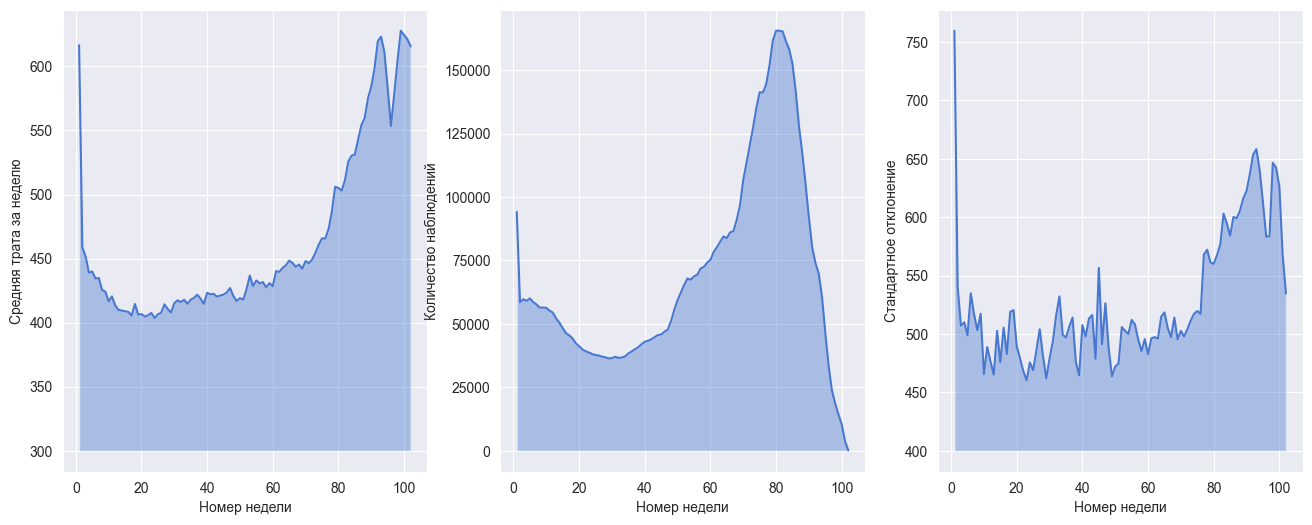

In [190]:
plt.figure(figsize=(16, 6))
sns.set_palette(palette='muted')
sns.set_style("darkgrid")
plt.subplot(131)
sns.lineplot(table, x='weeks', y='avg_purchase')
plt.fill_between(table.weeks, table.avg_purchase, 300, alpha=0.4)
plt.xlabel('Номер недели')
plt.ylabel('Средняя трата за неделю')
plt.subplot(132)
sns.lineplot(table, x='weeks', y='num_of_observation')
plt.fill_between(table.weeks, table.num_of_observation, alpha=0.4)
plt.xlabel('Номер недели')
plt.ylabel('Количество наблюдений')
plt.subplot(133)
sns.lineplot(table, x='weeks', y='std_purchase')
plt.fill_between(table.weeks, table.std_purchase, 400, alpha=0.4)
plt.xlabel('Номер недели')
plt.ylabel('Стандартное отклонение')
plt.show()

In [191]:
purch_group = purch[['weeks', 'sum_purchase']]
bins = [0, 4, 10, 30, 50, 70, 90, np.inf]
labels = ['1-4', '5-10', '11-30', '31-50', '51-70', '71-90', '91+']
purch_group['categories'] = pd.cut(purch_group['weeks'], bins=bins, labels=labels, right=True)

In [192]:
purch_group.head()

,weeks,sum_purchase,categories
0,70,1007,51-70
1,72,575,71-90
2,83,804,71-90
3,84,419,71-90
4,86,241,71-90


In [193]:
purch_group_std = purch_group.groupby('categories').sum_purchase.std().reset_index()

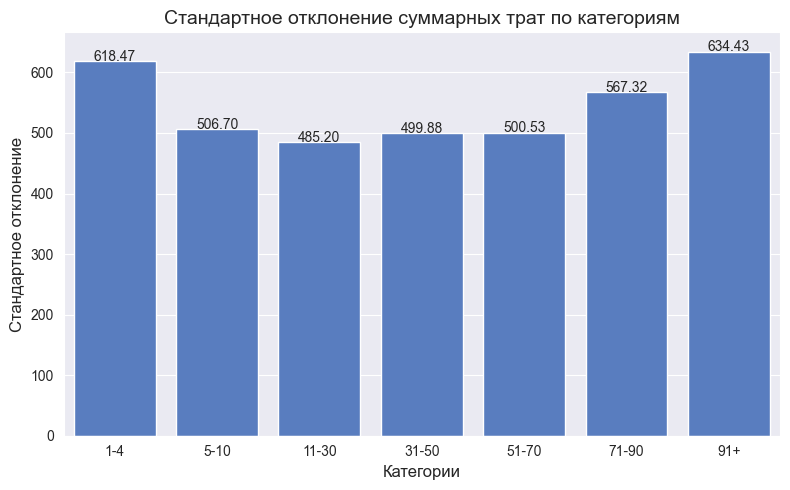

In [200]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=purch_group_std, x='categories', y='sum_purchase')
plt.title('Стандартное отклонение суммарных трат по категориям', fontsize=14)
plt.xlabel('Категории', fontsize=12)
plt.ylabel('Стандартное отклонение', fontsize=12)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.5, f'{p.get_height():.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

Высокие значения стандартного отклонения в группе 1-4 объяснить достаточно просто: новый клиент еще не выбрал стратегию взаимодействия с магазином, дополнительный фактор в виде бонусов и скидок позволяет тратить суммы, значительно больше обычного. Но вопрос: почему рост стандартного отклонения мы наблюдаем для постоянных клиентов после 70-й недели?

Сначала проверим, за счет чего происходит это изменение: за счет увеличения количества нулевых трат или большего веса хвоста распределения.

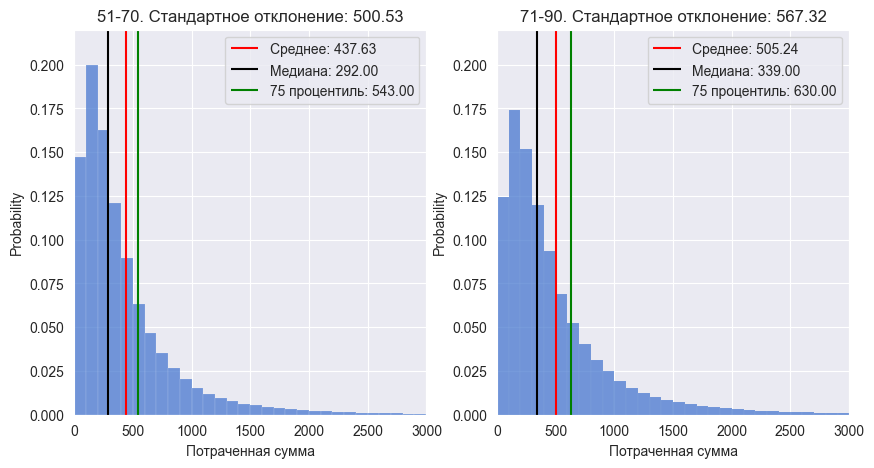

In [203]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
std_1 = purch_group[purch_group.categories == '51-70'].sum_purchase.std()
plt.title(f'51-70. Стандартное отклонение: {std_1:.2f}')
sns.histplot(purch_group[purch_group.categories == '51-70'], x='sum_purchase', stat='probability', binwidth=100)
m1 = purch_group[purch_group.categories == '51-70'].sum_purchase.mean()
med1 = purch_group[purch_group.categories == '51-70'].sum_purchase.median()
q1 = purch_group[purch_group.categories == '51-70'].sum_purchase.quantile(0.75)
plt.vlines(x=m1, ymin=0, ymax=0.25, color='red', label=f'Среднее: {m1:.2f}')
plt.vlines(x=med1, ymin=0, ymax=0.25, color='black', label=f'Медиана: {med1:.2f}')
plt.vlines(x=q1, ymin=0, ymax=0.25, color='green', label=f'75 процентиль: {q1:.2f}')
plt.xlabel('Потраченная сумма')
plt.legend()
plt.xlim(0, 3000)
plt.ylim(0, 0.22)
plt.subplot(122)
std_2 = purch_group[purch_group.categories == '71-90'].sum_purchase.std()
plt.title(f'71-90. Стандартное отклонение: {std_2:.2f}')
sns.histplot(purch_group[purch_group.categories == '71-90'], x='sum_purchase', stat='probability', binwidth=100)
m2 = purch_group[purch_group.categories == '71-90'].sum_purchase.mean()
med2 = purch_group[purch_group.categories == '71-90'].sum_purchase.median()
q2 = purch_group[purch_group.categories == '71-90'].sum_purchase.quantile(0.75)
plt.vlines(x=m2, ymin=0, ymax=0.25, color='red',  label=f'Среднее: {m2:.2f}')
plt.vlines(x=med2, ymin=0, ymax=0.25, color='black', label=f'Медиана: {med2:.2f}')
plt.vlines(x=q2, ymin=0, ymax=0.25, color='green', label=f'75 процентиль: {q2:.2f}')
plt.xlabel('Потраченная сумма')
plt.legend()
plt.xlim(0, 3000)
plt.ylim(0, 0.22)
plt.show()

Как можем судить по гистограммному изображению плотности распределения, правый хвост у второго распределения имеет больший вес, перемещение медианы относительно среднего менее значимо.

In [204]:
cls_start = purchases[purchases.client_id.isin(clients[clients.first_issue_date >= purchases.transaction_datetime.min()].client_id)].groupby('client_id').weeks.min().reset_index()
cls_start = pd.merge(cls_start, purchases, on=['client_id', 'weeks'], how='left').groupby(['client_id', 'weeks']).sum_purchase.sum().reset_index()

Несмотря на то, что есть отдельный проект с A/B-тестами, покажем здесь, что использование статистических тестов на реальных, не синтетических данных работает нормально.

Функция оценки необходимого размера выборки.

In [206]:
def estimate_sample_size(effect, std, alpha, beta):
    t_alpha = scipy.stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = scipy.stats.norm.ppf(1 - beta, loc=0, scale=1)
    var = 2 * std ** 2
    sample_size = int((t_alpha + t_beta) ** 2 * var / (effect ** 2))
    return sample_size

In [207]:
estimate_sample_size(100, purchases.sum_purchase.std(), 0.05, 0.2)

461

In [208]:
arr_of_dates = purchases.transaction_datetime.unique()
results_AA = []
results_AB = []
results_AB_not_equal_var = []
SAMPLE_SIZE = 461
for _ in tqdm(range(300)):
    date_ = np.random.choice(arr_of_dates, size=1)
    data_ = purchases[(purchases.transaction_datetime >= date_[0]) & (purchases.transaction_datetime <= date_[0] + pd.Timedelta(days=6))]
    smpl = data_.sum_purchase.sample(2 * SAMPLE_SIZE)
    smpl2 = smpl[:SAMPLE_SIZE]
    smpl = smpl[SAMPLE_SIZE:]
    results_AA.append(ttest_ind(smpl, smpl2).pvalue)
    smpl2 = smpl2 + 100
    results_AB.append(ttest_ind(smpl, smpl2).pvalue)
    results_AB_not_equal_var.append(ttest_ind(smpl, smpl2, equal_var=False).pvalue)

100%|██████████| 300/300 [03:19<00:00,  1.50it/s]


Видим, что классический t-тест корректно работает на исторических данных, находит интересующий нас эффект в 100 рублей на 5-процентном уровне значимости с ожидаемой ошибкой второго рода = 0.2. При этом не наблюдается проблем с распределением p-value.

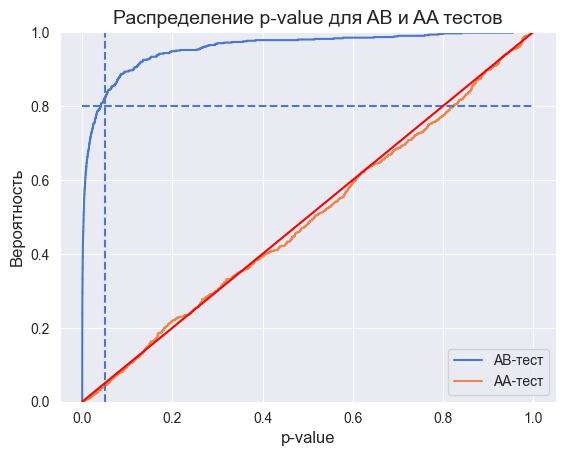

In [216]:
x_ = np.linspace(0, 1, 100)
sns.ecdfplot(results_AB, label='AB-тест')
sns.ecdfplot(results_AA, label='AА-тест')
plt.legend()
plt.vlines(x=0.05, ymin=0, ymax=1, linestyles='--')
plt.hlines(y=0.8, xmin=0, xmax=1, linestyles='--')
plt.plot(x_, x_, color='r')
plt.title('Распределение p-value для AB и AA тестов', fontsize=14)
plt.xlabel('p-value', fontsize=12)
plt.ylabel('Вероятность', fontsize=12)
plt.show()

In [ ]:
arr_of_dates_ = purchases.transaction_datetime.unique()
results_AA_ = []
results_AB_ = []

NUM_REPEATS = 10
NUM_EXPERIMENTS = 200
SAMPLE_SIZE = 461
for _ in tqdm(range(int(NUM_EXPERIMENTS / NUM_REPEATS))):
    date_ = np.random.choice(arr_of_dates, size=1)
    date_2 = date_[0] + pd.Timedelta(days=6)
    date_ = date_[0]
    data_ = purchases[(purchases.transaction_datetime >= date_) & (purchases.transaction_datetime <= date_ + pd.Timedelta(days=6))]
    data_ = data_.groupby('client_id').sum_purchase.sum().reset_index()
    data_2 = purchases[(purchases.transaction_datetime >= date_2) & (purchases.transaction_datetime <= date_2 + pd.Timedelta(days=6))]
    data_2 = data_2.groupby('client_id').sum_purchase.sum().reset_index()
    data_ = pd.merge(data_, data_2, on='client_id', how='outer').fillna(0)
    data_temp = data_.iloc[:, 2] - data_.iloc[:, 1]
    avg_score = data_temp.mean()
    for i in range(NUM_REPEATS):
        smpl = data_temp.sample(SAMPLE_SIZE)
        results_AA_.append(scipy.stats.ttest_1samp(smpl, avg_score).pvalue)

100%|██████████| 20/20 [00:57<00:00,  2.89s/it]


Мы также видим, что одновыборочный t-тест корректно работает для определения среднего, значит, им можно спокойно пользоваться на реальных исторических данных.

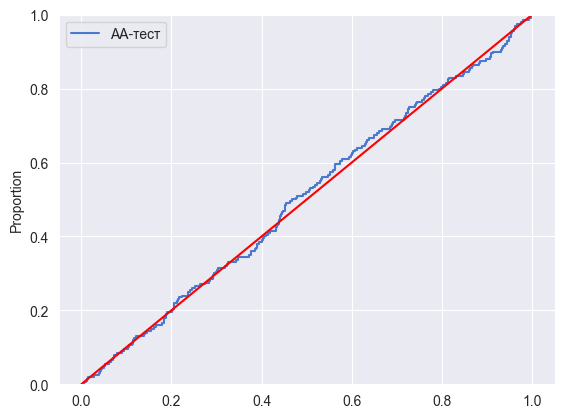

In [ ]:
x_ = np.linspace(0, 1, 100)
sns.ecdfplot(results_AA_, label='AА-тест')
plt.legend()
plt.plot(x_, x_, color='r')
plt.show()

Исследуем связь количества клиентских трат и количества магазинов, которые они посещают. Интуитивно подразумеваем, что обычный клиент посещает 1 или 2 магазина.

In [ ]:
clients_and_stores = pd.read_csv('purchases.csv', usecols=['client_id', 'transaction_id', 'store_id', 'transaction_datetime'])
clients_and_stores = clients_and_stores.drop_duplicates()
clients_and_stores.transaction_datetime = pd.to_datetime(clients_and_stores.transaction_datetime).dt.normalize()

In [ ]:
clients_and_stores.head()

,client_id,transaction_id,transaction_datetime,store_id
0,000012768d,7e3e2e3984,2018-12-01,54a4a11a29
19,000012768d,c1ca85d462,2018-12-16,ed8d2683fd
30,000012768d,6a0e96d0bc,2019-03-08,017c89b915
46,000012768d,b34f23306e,2019-03-14,017c89b915
52,000036f903,12b218b054,2018-11-28,6381a55c22


In [ ]:
clients_and_stores.to_csv('clients_and_stores.csv', index=False)

In [218]:
clients_and_stores = pd.read_csv('clients_and_stores.csv')

In [219]:
cls_strs = clients_and_stores.groupby('client_id').store_id.nunique().reset_index()

Оказывается, что есть много клиентов, которые посещают 20 магазинов и более, а потом их можно выделить в отдельную когорту.

In [220]:
outliers = purchases[purchases.client_id.isin(cls_strs[cls_strs.store_id > 20].client_id)]
outliers_grp = outliers.groupby('client_id').agg({"sum_purchase": ['count', 'sum']}).reset_index()
outliers_grp.columns = ['client_id', 'num_purch', 'sum_purch']

not_outliers =purchases[purchases.client_id.isin(cls_strs[cls_strs.store_id <= 20].client_id)]
not_outliers_grp = not_outliers.groupby('client_id').agg({"sum_purchase": ['count', 'sum']}).reset_index()
not_outliers_grp.columns = ['client_id', 'num_purch', 'sum_purch']

outliers_grp['outlier'] = 1
df2 = not_outliers_grp.sample(outliers_grp.shape[0])
df2['outlier'] = 0
df = pd.concat((outliers_grp, df2), axis=0)

model1 = LinearRegression()
model2 = LinearRegression()
model1.fit(sm.add_constant(outliers_grp.num_purch), outliers_grp.sum_purch)
X_out = [outliers_grp.num_purch.min(), outliers_grp.num_purch.max()]
y_out = model1.predict(sm.add_constant(X_out))

model2.fit(sm.add_constant(df2.num_purch), df2.sum_purch)
X_not_out = [df2.num_purch.min(), df2.num_purch.max()]
y_not_out = model2.predict(sm.add_constant(X_not_out))

Видим, что клиенты, посещающие больше магазинов, имеют большие показатели среднего чека.

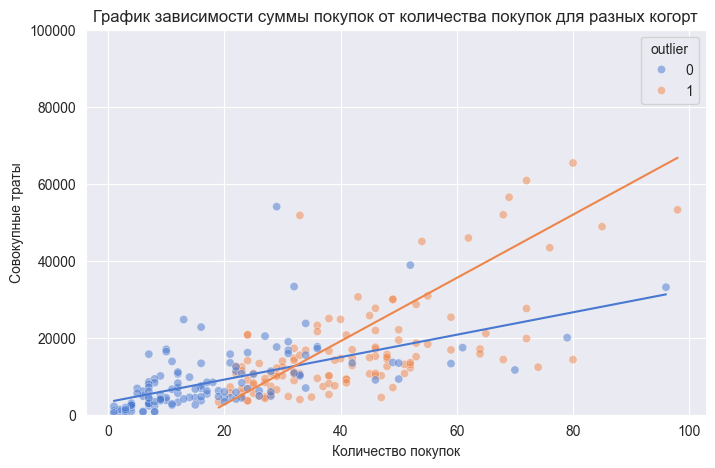

In [225]:
plt.figure(figsize=(8, 5))
plt.ylim(0, 100000)
sns.lineplot(pd.DataFrame(np.vstack((np.array(X_not_out), y_not_out)).T, columns=['x', 'y']), x='x', y='y')
sns.lineplot(pd.DataFrame(np.vstack((np.array(X_out), y_out)).T, columns=['x', 'y']), x='x', y='y')
sns.scatterplot(df, x='num_purch', y='sum_purch', hue='outlier', alpha=0.5)
plt.xlabel('Количество покупок')
plt.ylabel('Совокупные траты')
plt.title('График зависимости суммы покупок от количества покупок для разных когорт')
plt.show()

Видим, что нельзя также установить границу, например, на 10 магазинах. То есть можно сказать, что посещение 10 различных магазинов – норма для клиентов. Их нельзя считать отдельной когортой.

In [226]:
BOUND = 10

outliers = purchases[purchases.client_id.isin(cls_strs[cls_strs.store_id > BOUND].client_id)]
outliers_grp = outliers.groupby('client_id').agg({"sum_purchase": ['count', 'sum']}).reset_index()
outliers_grp.columns = ['client_id', 'num_purch', 'sum_purch']

not_outliers =purchases[purchases.client_id.isin(cls_strs[cls_strs.store_id <= BOUND].client_id)]
not_outliers_grp = not_outliers.groupby('client_id').agg({"sum_purchase": ['count', 'sum']}).reset_index()
not_outliers_grp.columns = ['client_id', 'num_purch', 'sum_purch']

outliers_grp['outlier'] = 1
df2 = not_outliers_grp.sample(outliers_grp.shape[0])
df2['outlier'] = 0
df = pd.concat((outliers_grp, df2), axis=0)

model1 = LinearRegression()
model2 = LinearRegression()
model1.fit(sm.add_constant(outliers_grp.num_purch), outliers_grp.sum_purch)
X_out = [outliers_grp.num_purch.min(), outliers_grp.num_purch.max()]
y_out = model1.predict(sm.add_constant(X_out))

model2.fit(sm.add_constant(df2.num_purch), df2.sum_purch)
X_not_out = [df2.num_purch.min(), df2.num_purch.max()]
y_not_out = model2.predict(sm.add_constant(X_not_out))

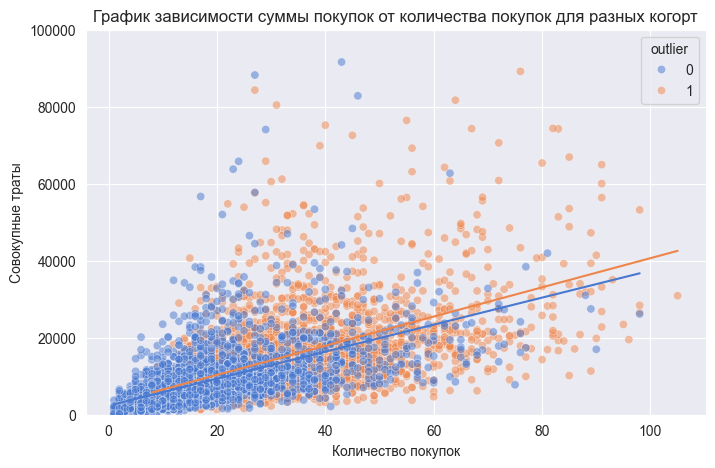

In [227]:
plt.figure(figsize=(8, 5))
plt.ylim(0, 100000)
sns.lineplot(pd.DataFrame(np.vstack((np.array(X_not_out), y_not_out)).T, columns=['x', 'y']), x='x', y='y')
sns.lineplot(pd.DataFrame(np.vstack((np.array(X_out), y_out)).T, columns=['x', 'y']), x='x', y='y')
sns.scatterplot(df, x='num_purch', y='sum_purch', hue='outlier', alpha=0.5)
plt.xlabel('Количество покупок')
plt.ylabel('Совокупные траты')
plt.title('График зависимости суммы покупок от количества покупок для разных когорт')
plt.show()